# Homework: Task 2 and Task 3
## Task 2: implement neural network for binary classification: countryside and metropolitian images

In [1]:
import numpy as np 
import os
import sys
import cv2
import matplotlib.pyplot as plt
import skimage
import random
from sklearn import model_selection

## Features extraction using K-mean clustering

### Function return the closet cluster centroid to each sample in data

In [2]:
def findClosetCentroids(data,centroids):
    """Return the closet centroid index to each data point"""
    nSample=data.shape[0]
    #number of clusters
    K=centroids.shape[0]
    index=np.zeros((nSample,1))
    temp=np.zeros((K,1))
    for i in range(nSample):
        for j in range(K):
            temp[j]=np.sum((data[i,:]-centroids[j,:])**2)
            index[i]=np.argmin(temp)
    return index

### Function to update the cluster's centroid base on the mean of members in each cluster

In [3]:
def updateCentroids(data,index,K):
    """Update the centroids"""
    temp=np.zeros((K,data.shape[1]))
    count=np.zeros((K,1))
    for i in range(index.shape[0]):
        temp[int(index[i])]+=data[i]
        count[int(index[i])]+=1
    for i in range(K):
        if count[i,0]==0:
            count[i,0]=1
    centroids=temp/count
    return centroids,count

### Initialize centroids list randomlly, each one is picked in the data sample

In [4]:
def randomInitCentroids(data,K):
    centroids=np.zeros((K,data.shape[1]))
    for i in range(K):
        flag=True
        while flag:
            flag=False
            centroids[i]=data[np.random.randint(0,data.shape[0])]
            for j in range(i):
                if (centroids[i]==centroids[j]).all():
                    flag=True
                    break
    return centroids

### K-mean clustering algorithm

In [5]:
def KmeanClustering(data,K,epoch=500):
    """K-mean clustering implementation"""
    centroids=randomInitCentroids(data,K)
    for i in range(epoch):
        index=findClosetCentroids(data,centroids)
        centroids,count=updateCentroids(data,index,centroids.shape[0])
    return centroids,count

## Feature extraction using K-mean clustering
Using K-mean clustering with 3 clusters, 20 iterations
Finding the most dominant colors, sort by frequency, and then flatten
Because of the long computation time for k-mean clustering, we reuse the X and y extracted from **assignment 3.**
1. "centroids_x.npy" contain features extracted from 1720 image, as numpy array with shape(1720x10)(firt col is 1 only-bias feature).
2. "label_y.npy" contain label array with shape(1720x1), each element is 0 or 1

In [6]:
K=3
nIterations=20
# Code for feature extraction using K-mean clustering

# country_filename=[os.path.join("countryside",name) for name in os.listdir("countryside")]
# metro_filename=[os.path.join("metropolitian",name) for name in os.listdir("metropolitian")]
# X=np.ones((len(country_filename)+len(metro_filename),3*K+1))
# y=np.zeros((len(country_filename)+len(metro_filename),1))

# for idx,filename in enumerate(country_filename+metro_filename):
#     print(idx,filename)
#     img=skimage.io.imread(filename)
#     img=skimage.transform.resize(img,(img.shape[0]//16,img.shape[1]//16,3))
#     data=img.reshape(-1,3)
#     centroids,count=KmeanClustering(data,K,nIterations)
#     #sorted by color frequency
#     count_list=[count[i,0] for i in range(count.shape[0])]
#     sorted_pair=sorted(zip(count_list,centroids),key=lambda x:x[0],reverse=True)
#     sorted_centroids=[pair[1] for pair in sorted_pair]
#     centroids=np.concatenate(sorted_centroids)
#     print(centroids)
#     X[idx,1:]=centroids
#     #label sample
#     if filename[0]=='c':
#         y[idx]=1
#     else:
#         y[idx]=0
# #saving for next time using (may be)
# np.save("centroids_x",X)
# np.save("label_y",y)


X=np.load("centroids_x.npy")[:,1:]
y=np.load("label_y.npy")
print(X)
print(y)

[[0.2625817  0.28093897 0.13372842 ... 0.63941725 0.82881023 0.90813546]
 [0.39337513 0.4601746  0.24870402 ... 0.77470004 0.78699341 0.77795945]
 [0.84542074 0.83312417 0.83280256 ... 0.24550169 0.24801312 0.20565743]
 ...
 [0.08401549 0.05263273 0.04277357 ... 0.90273372 0.79293677 0.72325501]
 [0.56503868 0.67435558 0.81730446 ... 0.26592599 0.27272595 0.21238273]
 [0.14319835 0.13046703 0.12414007 ... 0.61164804 0.53173783 0.43096392]]
[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [0.]]


In [7]:
#training and validation set splitting: 75% for training and 25% for validation set
x_train,x_test,y_train,y_test=model_selection.train_test_split(X,y,test_size=0.25,random_state=42)

## Neural Network implementation

**We implement a general neural network which can be apply to a multiclass classification problem.  
Neural network has multi output layer units (one-hot coding)**

### Define activation function, such as Sigmoid or ReLU

In [8]:
class Activation:
    def compute(z):pass
    def gradient(z):pass

In [9]:
class Sigmoid(Activation):
    def compute(z):
        """
        return the sigmoid of z
        """

        return 1/ (1 + np.exp(-z))

    def gradient(z):
        """
        computes the gradient of the sigmoid function
        """
        sigmoid=1/ (1 + np.exp(-z))
        return sigmoid *(1-sigmoid)

In [10]:
class ReLU(Activation):
    def compute(z):
        """
        return the ReLU of z
        """
        return np.where(z>0,z,0)

    def gradient(z):
        """
        computes the gradient of the reLU function
        """
        return np.where(z>0,1,0)

### Neural network with 1 hidden layer
**Activation function we use in the hidden layer can be sigmoid or ReLU function, but in the output layer, we allway use sigmoid activation.**

### Feedforward propagation

In [11]:
def predict(Theta1, Theta2, X,Activation=Sigmoid):
    """
    Predict the label of an input given a trained neural network
    """
    m= X.shape[0]
    X = np.hstack((np.ones((m,1)),X))
    
    a1 = Activation.compute(X @ Theta1.T)
    a1 = np.hstack((np.ones((m,1)), a1)) # hidden layer
    a2 = Sigmoid.compute(a1 @ Theta2.T) # output layer
    
    return np.argmax(a2,axis=1)

### Compute the Neural Networks cost function

In [12]:
def nnCostFunction(nn_params,input_layer_size, hidden_layer_size, num_labels,X, y,Lambda,Activation=Sigmoid):
    """
    nn_params contains the parameters unrolled into a vector
    
    compute the cost and gradient of the neural network
    """
    # Reshape nn_params back into the parameters Theta1 and Theta2
    Theta1 = nn_params[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = nn_params[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)
    
    m = X.shape[0]
    J=0
    X = np.hstack((np.ones((m,1)),X))
    y10 = np.zeros((m,num_labels))
    
    a1 = Activation.compute(X @ Theta1.T)
    a1 = np.hstack((np.ones((m,1)), a1)) # hidden layer
    a2 = Sigmoid.compute(a1 @ Theta2.T) # output layer
    
    for i in range(num_labels):
        y10[:,i][:,np.newaxis] = np.where(y==i,1,0)
    for j in range(num_labels):
        J = J + sum(-y10[:,j] * np.log(a2[:,j]) - (1-y10[:,j])*np.log(1-a2[:,j]))
    
    cost = 1/m* J
    reg_J = cost + Lambda/(2*m) * (np.sum(Theta1[:,1:]**2) + np.sum(Theta2[:,1:]**2))
    
    # Implement the backpropagation algorithm to compute the gradients
    
    grad1 = np.zeros((Theta1.shape))
    grad2 = np.zeros((Theta2.shape))
    
    for i in range(m):
        xi= X[i,:]
        a1i = a1[i,:]
        a2i =a2[i,:]
        d2 = a2i - y10[i,:]
        d1 = Theta2.T @ d2.T * Activation.gradient(np.hstack((1,xi @ Theta1.T)))
        grad1= grad1 + d1[1:][:,np.newaxis] @ xi[:,np.newaxis].T
        grad2 = grad2 + d2.T[:,np.newaxis] @ a1i[:,np.newaxis].T
        
    grad1 = 1/m * grad1
    grad2 = 1/m*grad2
    
    grad1_reg = grad1 + (Lambda/m) * np.hstack((np.zeros((Theta1.shape[0],1)),Theta1[:,1:]))
    grad2_reg = grad2 + (Lambda/m) * np.hstack((np.zeros((Theta2.shape[0],1)),Theta2[:,1:]))
    
    return cost, grad1, grad2,reg_J, grad1_reg,grad2_reg

### Random initialization

Select values for $\Theta^{(l)}$ uniformly in the range $[-\epsilon_{init} , \epsilon_{init}]$

One effective strategy for choosing $\epsilon_{init}$ is to base it on the number of units in the network

$\epsilon_{init} = \frac{\sqrt{6}}{\sqrt{L_{in} + L_{out}}}$

In [13]:
def randInitializeWeights(L_in, L_out):
    """
    randomly initializes the weights of a layer with L_in incoming connections and L_out outgoing connections.
    """
    
    epi = (6**1/2) / (L_in + L_out)**1/2
    
    W = np.random.rand(L_out,L_in +1) *(2*epi) -epi
    
    return W

## Neural network architecture
**Input layer size: 9.  
Hidden layer size: 9.(with Sigmoid or ReLU activations)  
Output layer size: 2 (with sigmoid activations)(coresponding to 2 class).**

In [14]:
input_layer_size  = 9
hidden_layer_size = 9
num_labels = 2

In [15]:
initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)
initial_nn_params = np.append(initial_Theta1.flatten(),initial_Theta2.flatten())

In [21]:
def gradientDescentnn(X,y,initial_nn_params,alpha,num_iters,Lambda,input_layer_size, hidden_layer_size, num_labels,Activation=Sigmoid):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    
    return theta and the list of the cost of theta during each iteration
    """
    Theta1 = initial_nn_params[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
    Theta2 = initial_nn_params[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)
    
    m=len(y)
    J_history =[]
    train_acc_history=[]
    test_acc_history=[]
    
    for i in range(num_iters):
        print("Iteration number",i)
        nn_params = np.append(Theta1.flatten(),Theta2.flatten())
        cost, grad1, grad2 = nnCostFunction(nn_params,input_layer_size, hidden_layer_size, num_labels,X, y,Lambda,Activation)[3:]
        print("Cost:",cost)
        Theta1 = Theta1 - (alpha * grad1)
        Theta2 = Theta2 - (alpha * grad2)
        J_history.append(cost)
        
        
        pred_train = predict(Theta1, Theta2, x_train)
        train_acc_history.append(sum(pred_train[:,np.newaxis]==y_train)[0]/y_train.shape[0]*100)
        pred_test = predict(Theta1, Theta2, x_test)
        test_acc_history.append(sum(pred_test[:,np.newaxis]==y_test)[0]/y_test.shape[0]*100)
    
    nn_paramsFinal = np.append(Theta1.flatten(),Theta2.flatten())
    return nn_paramsFinal , J_history,train_acc_history,test_acc_history

In [23]:
print("Start training..")
sigmoid_nnTheta, sigmoid_nnJ_history,sigmoid_train_acc_history,sigmoid_test_acc_history= gradientDescentnn(x_train,y_train,initial_nn_params,1,15000,0,input_layer_size, hidden_layer_size, num_labels)
sigmoid_Theta1 = sigmoid_nnTheta[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
sigmoid_Theta2 = sigmoid_nnTheta[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)

Start training..
Iteration number 0
Cost: 1.3958807958008306
Result:
Iteration number 1
Cost: 1.3852443486509225
Result:
Iteration number 2
Cost: 1.3849042622297119
Result:
Iteration number 3
Cost: 1.3848748813445342
Result:
Iteration number 4
Cost: 1.3848551935131528
Result:
Iteration number 5
Cost: 1.3848358476708094
Result:
Iteration number 6
Cost: 1.384816540271572
Result:
Iteration number 7
Cost: 1.3847972507770023
Result:
Iteration number 8
Cost: 1.3847779675409315
Result:
Iteration number 9
Cost: 1.384758679219559
Result:
Iteration number 10
Cost: 1.384739374497188
Result:
Iteration number 11
Cost: 1.3847200420717622
Result:
Iteration number 12
Cost: 1.38470067064849
Result:
Iteration number 13
Cost: 1.384681248933753
Result:
Iteration number 14
Cost: 1.3846617656290776
Result:
Iteration number 15
Cost: 1.384642209425132
Result:
Iteration number 16
Cost: 1.3846225689958434
Result:
Iteration number 17
Cost: 1.3846028329924698
Result:
Iteration number 18
Cost: 1.384582990037793
Re

Cost: 1.3734364579501048
Result:
Iteration number 157
Cost: 1.37322399091236
Result:
Iteration number 158
Cost: 1.3730086705095563
Result:
Iteration number 159
Cost: 1.3727904922180476
Result:
Iteration number 160
Cost: 1.3725694525000118
Result:
Iteration number 161
Cost: 1.3723455488124467
Result:
Iteration number 162
Cost: 1.3721187796147485
Result:
Iteration number 163
Cost: 1.371889144374772
Result:
Iteration number 164
Cost: 1.3716566435733648
Result:
Iteration number 165
Cost: 1.3714212787072795
Result:
Iteration number 166
Cost: 1.3711830522904178
Result:
Iteration number 167
Cost: 1.3709419678533978
Result:
Iteration number 168
Cost: 1.3706980299413314
Result:
Iteration number 169
Cost: 1.3704512441098409
Result:
Iteration number 170
Cost: 1.3702016169192028
Result:
Iteration number 171
Cost: 1.3699491559266486
Result:
Iteration number 172
Cost: 1.3696938696767493
Result:
Iteration number 173
Cost: 1.3694357676898654
Result:
Iteration number 174
Cost: 1.369174860448649
Result:

Cost: 1.311247283675369
Result:
Iteration number 313
Cost: 1.3106489914420807
Result:
Iteration number 314
Cost: 1.3100476375943093
Result:
Iteration number 315
Cost: 1.30944323821342
Result:
Iteration number 316
Cost: 1.3088358107668994
Result:
Iteration number 317
Cost: 1.3082253740962173
Result:
Iteration number 318
Cost: 1.3076119484028048
Result:
Iteration number 319
Cost: 1.306995555232192
Result:
Iteration number 320
Cost: 1.3063762174563656
Result:
Iteration number 321
Cost: 1.3057539592543586
Result:
Iteration number 322
Cost: 1.3051288060911215
Result:
Iteration number 323
Cost: 1.3045007846947527
Result:
Iteration number 324
Cost: 1.3038699230321067
Result:
Iteration number 325
Cost: 1.3032362502828487
Result:
Iteration number 326
Cost: 1.3025997968120475
Result:
Iteration number 327
Cost: 1.3019605941412982
Result:
Iteration number 328
Cost: 1.3013186749185337
Result:
Iteration number 329
Cost: 1.3006740728865238
Result:
Iteration number 330
Cost: 1.300026822850162
Result:


Cost: 1.2034818968497552
Result:
Iteration number 469
Cost: 1.2028221450448828
Result:
Iteration number 470
Cost: 1.2021635117751432
Result:
Iteration number 471
Cost: 1.2015059959029541
Result:
Iteration number 472
Cost: 1.2008495961423702
Result:
Iteration number 473
Cost: 1.200194311066676
Result:
Iteration number 474
Cost: 1.1995401391158655
Result:
Iteration number 475
Cost: 1.1988870786040218
Result:
Iteration number 476
Cost: 1.1982351277265895
Result:
Iteration number 477
Cost: 1.1975842845675209
Result:
Iteration number 478
Cost: 1.1969345471063375
Result:
Iteration number 479
Cost: 1.196285913225046
Result:
Iteration number 480
Cost: 1.1956383807149464
Result:
Iteration number 481
Cost: 1.194991947283348
Result:
Iteration number 482
Cost: 1.1943466105601237
Result:
Iteration number 483
Cost: 1.1937023681041772
Result:
Iteration number 484
Cost: 1.1930592174097652
Result:
Iteration number 485
Cost: 1.192417155912722
Result:
Iteration number 486
Cost: 1.1917761809965348
Result:

Cost: 1.200563281022283
Result:
Iteration number 624
Cost: 1.1978910065488169
Result:
Iteration number 625
Cost: 1.195390101335336
Result:
Iteration number 626
Cost: 1.1937261029323338
Result:
Iteration number 627
Cost: 1.1922504883586935
Result:
Iteration number 628
Cost: 1.1915778751544917
Result:
Iteration number 629
Cost: 1.1910479950917507
Result:
Iteration number 630
Cost: 1.191290806773474
Result:
Iteration number 631
Cost: 1.1915904207934467
Result:
Iteration number 632
Cost: 1.1926293098704732
Result:
Iteration number 633
Cost: 1.1935943671864142
Result:
Iteration number 634
Cost: 1.195239785088522
Result:
Iteration number 635
Cost: 1.1966255994088166
Result:
Iteration number 636
Cost: 1.1985839173376909
Result:
Iteration number 637
Cost: 1.2000484694234859
Result:
Iteration number 638
Cost: 1.2019239649534408
Result:
Iteration number 639
Cost: 1.2030668728715523
Result:
Iteration number 640
Cost: 1.204435602532117
Result:
Iteration number 641
Cost: 1.2049055307833516
Result:


Cost: 1.1548616796206617
Result:
Iteration number 778
Cost: 1.1542766864181793
Result:
Iteration number 779
Cost: 1.1543478663342557
Result:
Iteration number 780
Cost: 1.1537569768703149
Result:
Iteration number 781
Cost: 1.1538317250837795
Result:
Iteration number 782
Cost: 1.1532314478252434
Result:
Iteration number 783
Cost: 1.1533069926302317
Result:
Iteration number 784
Cost: 1.152695175646764
Result:
Iteration number 785
Cost: 1.1527700944688029
Result:
Iteration number 786
Cost: 1.1521461597067673
Result:
Iteration number 787
Cost: 1.152220478304236
Result:
Iteration number 788
Cost: 1.1515853270330416
Result:
Iteration number 789
Cost: 1.1516603326622101
Result:
Iteration number 790
Cost: 1.151015980096292
Result:
Iteration number 791
Cost: 1.1510938203440484
Result:
Iteration number 792
Cost: 1.1504428644984612
Result:
Iteration number 793
Cost: 1.1505260368014913
Result:
Iteration number 794
Cost: 1.1498710857547771
Result:
Iteration number 795
Cost: 1.1499619296538348
Result

Cost: 1.1146375809068738
Result:
Iteration number 934
Cost: 1.1132284952904592
Result:
Iteration number 935
Cost: 1.114121815283369
Result:
Iteration number 936
Cost: 1.1126906914531343
Result:
Iteration number 937
Cost: 1.1136046381281508
Result:
Iteration number 938
Cost: 1.1121510970126254
Result:
Iteration number 939
Cost: 1.1130860051699196
Result:
Iteration number 940
Cost: 1.1116096689917532
Result:
Iteration number 941
Cost: 1.112565867154115
Result:
Iteration number 942
Cost: 1.1110663593632737
Result:
Iteration number 943
Cost: 1.1120441683908684
Result:
Iteration number 944
Cost: 1.1105211144414708
Result:
Iteration number 945
Cost: 1.1115208467944362
Result:
Iteration number 946
Cost: 1.1099738756391866
Result:
Iteration number 947
Cost: 1.1109958351955396
Result:
Iteration number 948
Cost: 1.1094245812718944
Result:
Iteration number 949
Cost: 1.1104690635292909
Result:
Iteration number 950
Cost: 1.1088731689666274
Result:
Iteration number 951
Cost: 1.1099404614202268
Resul

Cost: 1.0666007324977709
Result:
Iteration number 1089
Cost: 1.069221353574043
Result:
Iteration number 1090
Cost: 1.0659824729168148
Result:
Iteration number 1091
Cost: 1.068617930006357
Result:
Iteration number 1092
Cost: 1.0653657761858493
Result:
Iteration number 1093
Cost: 1.068015853328935
Result:
Iteration number 1094
Cost: 1.0647506806030362
Result:
Iteration number 1095
Cost: 1.067415168979181
Result:
Iteration number 1096
Cost: 1.0641372219662963
Result:
Iteration number 1097
Cost: 1.0668159199112817
Result:
Iteration number 1098
Cost: 1.0635254336407571
Result:
Iteration number 1099
Cost: 1.0662181466416325
Result:
Iteration number 1100
Cost: 1.0629153466288668
Result:
Iteration number 1101
Cost: 1.065621887298556
Result:
Iteration number 1102
Cost: 1.06230698964282
Result:
Iteration number 1103
Cost: 1.0650271776758686
Result:
Iteration number 1104
Cost: 1.0617003891789194
Result:
Iteration number 1105
Cost: 1.0644340512899084
Result:
Iteration number 1106
Cost: 1.061095569

Iteration number 1242
Cost: 1.0242872518854071
Result:
Iteration number 1243
Cost: 1.0277855377060852
Result:
Iteration number 1244
Cost: 1.0238031601428341
Result:
Iteration number 1245
Cost: 1.0273117761689587
Result:
Iteration number 1246
Cost: 1.0233204653256092
Result:
Iteration number 1247
Cost: 1.0268393963931408
Result:
Iteration number 1248
Cost: 1.0228391568071473
Result:
Iteration number 1249
Cost: 1.0263683870861573
Result:
Iteration number 1250
Cost: 1.0223592240954382
Result:
Iteration number 1251
Cost: 1.0258987370717982
Result:
Iteration number 1252
Cost: 1.0218806568350811
Result:
Iteration number 1253
Cost: 1.0254304352936257
Result:
Iteration number 1254
Cost: 1.0214034448090965
Result:
Iteration number 1255
Cost: 1.0249634708181652
Result:
Iteration number 1256
Cost: 1.020927577940493
Result:
Iteration number 1257
Cost: 1.0244978328378358
Result:
Iteration number 1258
Cost: 1.0204530462936396
Result:
Iteration number 1259
Cost: 1.0240335106736005
Result:
Iteration n

Cost: 0.9905087238514089
Result:
Iteration number 1397
Cost: 0.9947034180076254
Result:
Iteration number 1398
Cost: 0.9901109282023679
Result:
Iteration number 1399
Cost: 0.9943126811652824
Result:
Iteration number 1400
Cost: 0.9897140828221974
Result:
Iteration number 1401
Cost: 0.9939228308537403
Result:
Iteration number 1402
Cost: 0.9893181854951297
Result:
Iteration number 1403
Cost: 0.9935338645917178
Result:
Iteration number 1404
Cost: 0.988923234054601
Result:
Iteration number 1405
Cost: 0.9931457799581987
Result:
Iteration number 1406
Cost: 0.9885292263818465
Result:
Iteration number 1407
Cost: 0.9927585745909357
Result:
Iteration number 1408
Cost: 0.9881361604044967
Result:
Iteration number 1409
Cost: 0.992372246184973
Result:
Iteration number 1410
Cost: 0.9877440340952038
Result:
Iteration number 1411
Cost: 0.9919867924911824
Result:
Iteration number 1412
Cost: 0.9873528454702922
Result:
Iteration number 1413
Cost: 0.9916022113148071
Result:
Iteration number 1414
Cost: 0.9869

Cost: 0.963200909260295
Result:
Iteration number 1547
Cost: 0.9677418369144928
Result:
Iteration number 1548
Cost: 0.9628701859704548
Result:
Iteration number 1549
Cost: 0.9674132709250888
Result:
Iteration number 1550
Cost: 0.9625403119300534
Result:
Iteration number 1551
Cost: 0.9670854937447385
Result:
Iteration number 1552
Cost: 0.9622112859948297
Result:
Iteration number 1553
Cost: 0.9667585044785812
Result:
Iteration number 1554
Cost: 0.9618831070145886
Result:
Iteration number 1555
Cost: 0.9664323022284083
Result:
Iteration number 1556
Cost: 0.9615557738329957
Result:
Iteration number 1557
Cost: 0.9661068860923574
Result:
Iteration number 1558
Cost: 0.9612292852873847
Result:
Iteration number 1559
Cost: 0.9657822551646432
Result:
Iteration number 1560
Cost: 0.9609036402085624
Result:
Iteration number 1561
Cost: 0.9654584085352704
Result:
Iteration number 1562
Cost: 0.9605788374206384
Result:
Iteration number 1563
Cost: 0.965135345289774
Result:
Iteration number 1564
Cost: 0.9602

Cost: 0.9446765182145063
Result:
Iteration number 1702
Cost: 0.9398568231691256
Result:
Iteration number 1703
Cost: 0.9444055917493623
Result:
Iteration number 1704
Cost: 0.9395883100293203
Result:
Iteration number 1705
Cost: 0.9441353645444986
Result:
Iteration number 1706
Cost: 0.9393205330168267
Result:
Iteration number 1707
Cost: 0.9438658351260641
Result:
Iteration number 1708
Cost: 0.9390534903795092
Result:
Iteration number 1709
Cost: 0.9435970020134004
Result:
Iteration number 1710
Cost: 0.9387871803595301
Result:
Iteration number 1711
Cost: 0.9433288637191446
Result:
Iteration number 1712
Cost: 0.9385216011934517
Result:
Iteration number 1713
Cost: 0.9430614187493134
Result:
Iteration number 1714
Cost: 0.9382567511123383
Result:
Iteration number 1715
Cost: 0.9427946656034105
Result:
Iteration number 1716
Cost: 0.9379926283418789
Result:
Iteration number 1717
Cost: 0.9425286027745179
Result:
Iteration number 1718
Cost: 0.9377292311024797
Result:
Iteration number 1719
Cost: 0.94

Cost: 0.9212014711125232
Result:
Iteration number 1857
Cost: 0.9255244615394774
Result:
Iteration number 1858
Cost: 0.9209842415531081
Result:
Iteration number 1859
Cost: 0.9253032802646733
Result:
Iteration number 1860
Cost: 0.9207676043074772
Result:
Iteration number 1861
Cost: 0.9250826706766437
Result:
Iteration number 1862
Cost: 0.9205515574876096
Result:
Iteration number 1863
Cost: 0.924862631076543
Result:
Iteration number 1864
Cost: 0.9203360992071639
Result:
Iteration number 1865
Cost: 0.9246431597662905
Result:
Iteration number 1866
Cost: 0.9201212275815583
Result:
Iteration number 1867
Cost: 0.9244242550486387
Result:
Iteration number 1868
Cost: 0.9199069407280153
Result:
Iteration number 1869
Cost: 0.9242059152272367
Result:
Iteration number 1870
Cost: 0.9196932367656443
Result:
Iteration number 1871
Cost: 0.9239881386067134
Result:
Iteration number 1872
Cost: 0.9194801138154962
Result:
Iteration number 1873
Cost: 0.9237709234927347
Result:
Iteration number 1874
Cost: 0.919

Cost: 0.9064284221794416
Result:
Iteration number 2007
Cost: 0.9104095435082297
Result:
Iteration number 2008
Cost: 0.9062505539297604
Result:
Iteration number 2009
Cost: 0.9102266459000491
Result:
Iteration number 2010
Cost: 0.9060731443554765
Result:
Iteration number 2011
Cost: 0.9100441983316155
Result:
Iteration number 2012
Cost: 0.9058961918150998
Result:
Iteration number 2013
Cost: 0.9098621992955539
Result:
Iteration number 2014
Cost: 0.9057196946713187
Result:
Iteration number 2015
Cost: 0.909680647288078
Result:
Iteration number 2016
Cost: 0.9055436512910018
Result:
Iteration number 2017
Cost: 0.9094995408089934
Result:
Iteration number 2018
Cost: 0.9053680600452105
Result:
Iteration number 2019
Cost: 0.9093188783617124
Result:
Iteration number 2020
Cost: 0.9051929193092003
Result:
Iteration number 2021
Cost: 0.909138658453259
Result:
Iteration number 2022
Cost: 0.9050182274624297
Result:
Iteration number 2023
Cost: 0.9089588795942734
Result:
Iteration number 2024
Cost: 0.9048

Cost: 0.8939602627724168
Result:
Iteration number 2161
Cost: 0.8975378976753859
Result:
Iteration number 2162
Cost: 0.8938132162314695
Result:
Iteration number 2163
Cost: 0.8973855079944973
Result:
Iteration number 2164
Cost: 0.8936665141682769
Result:
Iteration number 2165
Cost: 0.8972334628471836
Result:
Iteration number 2166
Cost: 0.8935201552568772
Result:
Iteration number 2167
Cost: 0.8970817609990848
Result:
Iteration number 2168
Cost: 0.8933741381751059
Result:
Iteration number 2169
Cost: 0.8969304012190984
Result:
Iteration number 2170
Cost: 0.8932284616045865
Result:
Iteration number 2171
Cost: 0.8967793822793625
Result:
Iteration number 2172
Cost: 0.8930831242307304
Result:
Iteration number 2173
Cost: 0.8966287029552584
Result:
Iteration number 2174
Cost: 0.8929381247427192
Result:
Iteration number 2175
Cost: 0.8964783620253884
Result:
Iteration number 2176
Cost: 0.8927934618334951
Result:
Iteration number 2177
Cost: 0.8963283582715731
Result:
Iteration number 2178
Cost: 0.89

Cost: 0.8838026258235783
Result:
Iteration number 2311
Cost: 0.8869852019621866
Result:
Iteration number 2312
Cost: 0.8836779815520149
Result:
Iteration number 2313
Cost: 0.8868554360944207
Result:
Iteration number 2314
Cost: 0.8835535922965315
Result:
Iteration number 2315
Cost: 0.8867259306588723
Result:
Iteration number 2316
Cost: 0.883429456995484
Result:
Iteration number 2317
Cost: 0.8865966846451109
Result:
Iteration number 2318
Cost: 0.883305574590621
Result:
Iteration number 2319
Cost: 0.8864676970455694
Result:
Iteration number 2320
Cost: 0.8831819440270657
Result:
Iteration number 2321
Cost: 0.8863389668555637
Result:
Iteration number 2322
Cost: 0.883058564253325
Result:
Iteration number 2323
Cost: 0.8862104930732874
Result:
Iteration number 2324
Cost: 0.8829354342212945
Result:
Iteration number 2325
Cost: 0.8860822746998093
Result:
Iteration number 2326
Cost: 0.8828125528862554
Result:
Iteration number 2327
Cost: 0.8859543107390877
Result:
Iteration number 2328
Cost: 0.88268

Cost: 0.8777979497148157
Result:
Iteration number 2464
Cost: 0.8748781508085569
Result:
Iteration number 2465
Cost: 0.8776853039771172
Result:
Iteration number 2466
Cost: 0.8747702866789464
Result:
Iteration number 2467
Cost: 0.8775728503547233
Result:
Iteration number 2468
Cost: 0.8746626058791681
Result:
Iteration number 2469
Cost: 0.877460588067283
Result:
Iteration number 2470
Cost: 0.8745551076145266
Result:
Iteration number 2471
Cost: 0.8773485163375863
Result:
Iteration number 2472
Cost: 0.8744477910938223
Result:
Iteration number 2473
Cost: 0.8772366343915469
Result:
Iteration number 2474
Cost: 0.8743406555293517
Result:
Iteration number 2475
Cost: 0.8771249414581974
Result:
Iteration number 2476
Cost: 0.8742337001368966
Result:
Iteration number 2477
Cost: 0.8770134367696963
Result:
Iteration number 2478
Cost: 0.8741269241357251
Result:
Iteration number 2479
Cost: 0.8769021195613151
Result:
Iteration number 2480
Cost: 0.8740203267485802
Result:
Iteration number 2481
Cost: 0.876

Cost: 0.8670554612638759
Result:
Iteration number 2619
Cost: 0.8695334353228751
Result:
Iteration number 2620
Cost: 0.8669596306575265
Result:
Iteration number 2621
Cost: 0.869433656298352
Result:
Iteration number 2622
Cost: 0.8668639315832146
Result:
Iteration number 2623
Cost: 0.8693340170951968
Result:
Iteration number 2624
Cost: 0.8667683634744738
Result:
Iteration number 2625
Cost: 0.8692345171360452
Result:
Iteration number 2626
Cost: 0.8666729257668718
Result:
Iteration number 2627
Cost: 0.8691351558451827
Result:
Iteration number 2628
Cost: 0.8665776178979846
Result:
Iteration number 2629
Cost: 0.869035932648493
Result:
Iteration number 2630
Cost: 0.8664824393073675
Result:
Iteration number 2631
Cost: 0.8689368469734466
Result:
Iteration number 2632
Cost: 0.8663873894365223
Result:
Iteration number 2633
Cost: 0.8688378982490502
Result:
Iteration number 2634
Cost: 0.8662924677288579
Result:
Iteration number 2635
Cost: 0.8687390859058229
Result:
Iteration number 2636
Cost: 0.8661

Cost: 0.8623096312616402
Result:
Iteration number 2772
Cost: 0.8600220570330576
Result:
Iteration number 2773
Cost: 0.8622189067890811
Result:
Iteration number 2774
Cost: 0.8599348029403707
Result:
Iteration number 2775
Cost: 0.862128280685543
Result:
Iteration number 2776
Cost: 0.8598476404241254
Result:
Iteration number 2777
Cost: 0.8620377524107821
Result:
Iteration number 2778
Cost: 0.8597605689854992
Result:
Iteration number 2779
Cost: 0.861947321424119
Result:
Iteration number 2780
Cost: 0.8596735881255753
Result:
Iteration number 2781
Cost: 0.8618569871844419
Result:
Iteration number 2782
Cost: 0.8595866973453284
Result:
Iteration number 2783
Cost: 0.8617667491501858
Result:
Iteration number 2784
Cost: 0.8594998961456091
Result:
Iteration number 2785
Cost: 0.8616766067793216
Result:
Iteration number 2786
Cost: 0.859413184027134
Result:
Iteration number 2787
Cost: 0.8615865595293504
Result:
Iteration number 2788
Cost: 0.8593265604904629
Result:
Iteration number 2789
Cost: 0.86149

Cost: 0.8557411732597129
Result:
Iteration number 2922
Cost: 0.853698169174215
Result:
Iteration number 2923
Cost: 0.855656293324131
Result:
Iteration number 2924
Cost: 0.8536163831353152
Result:
Iteration number 2925
Cost: 0.8555714699124847
Result:
Iteration number 2926
Cost: 0.8535346505948658
Result:
Iteration number 2927
Cost: 0.8554867024562223
Result:
Iteration number 2928
Cost: 0.8534529710389306
Result:
Iteration number 2929
Cost: 0.8554019903869527
Result:
Iteration number 2930
Cost: 0.8533713439537082
Result:
Iteration number 2931
Cost: 0.8553173331364766
Result:
Iteration number 2932
Cost: 0.8532897688255532
Result:
Iteration number 2933
Cost: 0.855232730136811
Result:
Iteration number 2934
Cost: 0.8532082451409934
Result:
Iteration number 2935
Cost: 0.8551481808202139
Result:
Iteration number 2936
Cost: 0.8531267723867512
Result:
Iteration number 2937
Cost: 0.8550636846192083
Result:
Iteration number 2938
Cost: 0.8530453500497617
Result:
Iteration number 2939
Cost: 0.85497

Cost: 0.8494943321553955
Result:
Iteration number 3072
Cost: 0.8476785235402234
Result:
Iteration number 3073
Cost: 0.8494121601304463
Result:
Iteration number 3074
Cost: 0.8475993608399812
Result:
Iteration number 3075
Cost: 0.8493300044472153
Result:
Iteration number 3076
Cost: 0.8475202150729809
Result:
Iteration number 3077
Cost: 0.8492478646342946
Result:
Iteration number 3078
Cost: 0.8474410858042701
Result:
Iteration number 3079
Cost: 0.8491657402228127
Result:
Iteration number 3080
Cost: 0.8473619726010123
Result:
Iteration number 3081
Cost: 0.8490836307464834
Result:
Iteration number 3082
Cost: 0.8472828750325083
Result:
Iteration number 3083
Cost: 0.8490015357416301
Result:
Iteration number 3084
Cost: 0.8472037926702365
Result:
Iteration number 3085
Cost: 0.8489194547472181
Result:
Iteration number 3086
Cost: 0.8471247250878653
Result:
Iteration number 3087
Cost: 0.848837387304887
Result:
Iteration number 3088
Cost: 0.8470456718612949
Result:
Iteration number 3089
Cost: 0.848

Cost: 0.8416830528695323
Result:
Iteration number 3225
Cost: 0.843184460885284
Result:
Iteration number 3226
Cost: 0.8416041202710526
Result:
Iteration number 3227
Cost: 0.8431023941504993
Result:
Iteration number 3228
Cost: 0.8415251793988533
Result:
Iteration number 3229
Cost: 0.8430203170047461
Result:
Iteration number 3230
Cost: 0.8414462300489476
Result:
Iteration number 3231
Cost: 0.8429382292513721
Result:
Iteration number 3232
Cost: 0.8413672720211143
Result:
Iteration number 3233
Cost: 0.8428561306980367
Result:
Iteration number 3234
Cost: 0.8412883051189034
Result:
Iteration number 3235
Cost: 0.8427740211567197
Result:
Iteration number 3236
Cost: 0.8412093291496533
Result:
Iteration number 3237
Cost: 0.8426919004437354
Result:
Iteration number 3238
Cost: 0.841130343924488
Result:
Iteration number 3239
Cost: 0.8426097683797337
Result:
Iteration number 3240
Cost: 0.8410513492583427
Result:
Iteration number 3241
Cost: 0.8425276247897153
Result:
Iteration number 3242
Cost: 0.8409

Cost: 0.8355713254130622
Result:
Iteration number 3379
Cost: 0.8368263839636304
Result:
Iteration number 3380
Cost: 0.8354914409938331
Result:
Iteration number 3381
Cost: 0.8367432589936347
Result:
Iteration number 3382
Cost: 0.8354115438594049
Result:
Iteration number 3383
Cost: 0.8366601211356364
Result:
Iteration number 3384
Cost: 0.835331634097977
Result:
Iteration number 3385
Cost: 0.8365769705180105
Result:
Iteration number 3386
Cost: 0.8352517118011719
Result:
Iteration number 3387
Cost: 0.8364938072727977
Result:
Iteration number 3388
Cost: 0.835171777064007
Result:
Iteration number 3389
Cost: 0.8364106315356821
Result:
Iteration number 3390
Cost: 0.8350918299848824
Result:
Iteration number 3391
Cost: 0.8363274434459614
Result:
Iteration number 3392
Cost: 0.8350118706655554
Result:
Iteration number 3393
Cost: 0.8362442431465216
Result:
Iteration number 3394
Cost: 0.8349318992111172
Result:
Iteration number 3395
Cost: 0.836161030783814
Result:
Iteration number 3396
Cost: 0.83485

Cost: 0.830401825610937
Result:
Iteration number 3534
Cost: 0.8293132430375093
Result:
Iteration number 3535
Cost: 0.8303183116159402
Result:
Iteration number 3536
Cost: 0.8292328569796623
Result:
Iteration number 3537
Cost: 0.830234803090957
Result:
Iteration number 3538
Cost: 0.8291524734233362
Result:
Iteration number 3539
Cost: 0.8301513003526131
Result:
Iteration number 3540
Cost: 0.829072092642962
Result:
Iteration number 3541
Cost: 0.8300678037185651
Result:
Iteration number 3542
Cost: 0.8289917149141176
Result:
Iteration number 3543
Cost: 0.8299843135074689
Result:
Iteration number 3544
Cost: 0.8289113405135011
Result:
Iteration number 3545
Cost: 0.8299008300389427
Result:
Iteration number 3546
Cost: 0.8288309697188939
Result:
Iteration number 3547
Cost: 0.8298173536335272
Result:
Iteration number 3548
Cost: 0.8287506028091278
Result:
Iteration number 3549
Cost: 0.829733884612648
Result:
Iteration number 3550
Cost: 0.8286702400640521
Result:
Iteration number 3551
Cost: 0.829650

Cost: 0.8231518308970969
Result:
Iteration number 3689
Cost: 0.8239289720153423
Result:
Iteration number 3690
Cost: 0.8230724814269011
Result:
Iteration number 3691
Cost: 0.8238468640566113
Result:
Iteration number 3692
Cost: 0.8229931566609958
Result:
Iteration number 3693
Cost: 0.8237647867515181
Result:
Iteration number 3694
Cost: 0.8229138568735214
Result:
Iteration number 3695
Cost: 0.8236827403979232
Result:
Iteration number 3696
Cost: 0.8228345823376016
Result:
Iteration number 3697
Cost: 0.8236007252923729
Result:
Iteration number 3698
Cost: 0.8227553333253289
Result:
Iteration number 3699
Cost: 0.823518741730064
Result:
Iteration number 3700
Cost: 0.8226761101077416
Result:
Iteration number 3701
Cost: 0.8234367900048395
Result:
Iteration number 3702
Cost: 0.8225969129548099
Result:
Iteration number 3703
Cost: 0.823354870409157
Result:
Iteration number 3704
Cost: 0.8225177421354076
Result:
Iteration number 3705
Cost: 0.8232729832340826
Result:
Iteration number 3706
Cost: 0.8224

Cost: 0.8177950648485266
Result:
Iteration number 3842
Cost: 0.8171325529256437
Result:
Iteration number 3843
Cost: 0.8177160219838824
Result:
Iteration number 3844
Cost: 0.8170558115872267
Result:
Iteration number 3845
Cost: 0.8176370275897188
Result:
Iteration number 3846
Cost: 0.8169791119724259
Result:
Iteration number 3847
Cost: 0.8175580818256376
Result:
Iteration number 3848
Cost: 0.8169024542370185
Result:
Iteration number 3849
Cost: 0.8174791848491573
Result:
Iteration number 3850
Cost: 0.8168258385349503
Result:
Iteration number 3851
Cost: 0.8174003368157289
Result:
Iteration number 3852
Cost: 0.8167492650183261
Result:
Iteration number 3853
Cost: 0.8173215378787174
Result:
Iteration number 3854
Cost: 0.816672733837413
Result:
Iteration number 3855
Cost: 0.8172427881894183
Result:
Iteration number 3856
Cost: 0.816596245140636
Result:
Iteration number 3857
Cost: 0.8171640878970476
Result:
Iteration number 3858
Cost: 0.8165197990745773
Result:
Iteration number 3859
Cost: 0.8170

Cost: 0.8113544692374066
Result:
Iteration number 3997
Cost: 0.8117844962113497
Result:
Iteration number 3998
Cost: 0.8112812630755339
Result:
Iteration number 3999
Cost: 0.8117095585541001
Result:
Iteration number 4000
Cost: 0.8112081053569534
Result:
Iteration number 4001
Cost: 0.8116346757993573
Result:
Iteration number 4002
Cost: 0.8111349961028168
Result:
Iteration number 4003
Cost: 0.8115598479564012
Result:
Iteration number 4004
Cost: 0.8110619353327616
Result:
Iteration number 4005
Cost: 0.811485075032886
Result:
Iteration number 4006
Cost: 0.8109889230649154
Result:
Iteration number 4007
Cost: 0.8114103570348408
Result:
Iteration number 4008
Cost: 0.8109159593159005
Result:
Iteration number 4009
Cost: 0.8113356939666905
Result:
Iteration number 4010
Cost: 0.8108430441008535
Result:
Iteration number 4011
Cost: 0.8112610858312564
Result:
Iteration number 4012
Cost: 0.810770177433424
Result:
Iteration number 4013
Cost: 0.8111865326297723
Result:
Iteration number 4014
Cost: 0.8106

Cost: 0.8059981862195637
Result:
Iteration number 4147
Cost: 0.8063153639415711
Result:
Iteration number 4148
Cost: 0.8059285813600118
Result:
Iteration number 4149
Cost: 0.8062444733547047
Result:
Iteration number 4150
Cost: 0.8058590229911923
Result:
Iteration number 4151
Cost: 0.8061736346166385
Result:
Iteration number 4152
Cost: 0.8057895110489655
Result:
Iteration number 4153
Cost: 0.8061028476469452
Result:
Iteration number 4154
Cost: 0.8057200454684866
Result:
Iteration number 4155
Cost: 0.8060321123644762
Result:
Iteration number 4156
Cost: 0.8056506261842145
Result:
Iteration number 4157
Cost: 0.8059614286873837
Result:
Iteration number 4158
Cost: 0.8055812531299245
Result:
Iteration number 4159
Cost: 0.8058907965331201
Result:
Iteration number 4160
Cost: 0.8055119262387249
Result:
Iteration number 4161
Cost: 0.8058202158184637
Result:
Iteration number 4162
Cost: 0.8054426454430563
Result:
Iteration number 4163
Cost: 0.8057496864595218
Result:
Iteration number 4164
Cost: 0.80

Cost: 0.8007692286434925
Result:
Iteration number 4301
Cost: 0.8010018948214939
Result:
Iteration number 4302
Cost: 0.8007029801155587
Result:
Iteration number 4303
Cost: 0.8009347258973452
Result:
Iteration number 4304
Cost: 0.8006367719280336
Result:
Iteration number 4305
Cost: 0.8008676014497264
Result:
Iteration number 4306
Cost: 0.800570603996281
Result:
Iteration number 4307
Cost: 0.8008005213793157
Result:
Iteration number 4308
Cost: 0.8005044762358312
Result:
Iteration number 4309
Cost: 0.8007334855870023
Result:
Iteration number 4310
Cost: 0.8004383885623889
Result:
Iteration number 4311
Cost: 0.8006664939738967
Result:
Iteration number 4312
Cost: 0.8003723408918413
Result:
Iteration number 4313
Cost: 0.8005995464413384
Result:
Iteration number 4314
Cost: 0.8003063331402691
Result:
Iteration number 4315
Cost: 0.8005326428909093
Result:
Iteration number 4316
Cost: 0.8002403652239596
Result:
Iteration number 4317
Cost: 0.8004657832244458
Result:
Iteration number 4318
Cost: 0.800

Cost: 0.7959532416860218
Result:
Iteration number 4456
Cost: 0.7957169828554026
Result:
Iteration number 4457
Cost: 0.7958892354789272
Result:
Iteration number 4458
Cost: 0.7956536526442389
Result:
Iteration number 4459
Cost: 0.7958252674155798
Result:
Iteration number 4460
Cost: 0.7955903573655321
Result:
Iteration number 4461
Cost: 0.7957613374396652
Result:
Iteration number 4462
Cost: 0.7955270969740111
Result:
Iteration number 4463
Cost: 0.7956974454957194
Result:
Iteration number 4464
Cost: 0.7954638714251933
Result:
Iteration number 4465
Cost: 0.7956335915291368
Result:
Iteration number 4466
Cost: 0.7954006806753917
Result:
Iteration number 4467
Cost: 0.7955697754861665
Result:
Iteration number 4468
Cost: 0.7953375246817281
Result:
Iteration number 4469
Cost: 0.7955059973139345
Result:
Iteration number 4470
Cost: 0.7952744034021293
Result:
Iteration number 4471
Cost: 0.7954422569604366
Result:
Iteration number 4472
Cost: 0.7952113167953407
Result:
Iteration number 4473
Cost: 0.79

Cost: 0.7911334946969688
Result:
Iteration number 4610
Cost: 0.7909406195368979
Result:
Iteration number 4611
Cost: 0.791072328903997
Result:
Iteration number 4612
Cost: 0.7908799104836831
Result:
Iteration number 4613
Cost: 0.7910111997011342
Result:
Iteration number 4614
Cost: 0.7908192354880441
Result:
Iteration number 4615
Cost: 0.7909501071076109
Result:
Iteration number 4616
Cost: 0.7907585945757816
Result:
Iteration number 4617
Cost: 0.7908890511436889
Result:
Iteration number 4618
Cost: 0.7906979877736691
Result:
Iteration number 4619
Cost: 0.7908280318306455
Result:
Iteration number 4620
Cost: 0.7906374151094419
Result:
Iteration number 4621
Cost: 0.790767049190784
Result:
Iteration number 4622
Cost: 0.7905768766118061
Result:
Iteration number 4623
Cost: 0.7907061032474298
Result:
Iteration number 4624
Cost: 0.7905163723104327
Result:
Iteration number 4625
Cost: 0.7906451940249227
Result:
Iteration number 4626
Cost: 0.7904559022359555
Result:
Iteration number 4627
Cost: 0.7905

Iteration number 4759
Cost: 0.7866500994274171
Result:
Iteration number 4760
Cost: 0.7864848306750079
Result:
Iteration number 4761
Cost: 0.786591797174904
Result:
Iteration number 4762
Cost: 0.7864268098882763
Result:
Iteration number 4763
Cost: 0.7865335355922171
Result:
Iteration number 4764
Cost: 0.7863688275879378
Result:
Iteration number 4765
Cost: 0.7864753147653278
Result:
Iteration number 4766
Cost: 0.7863108838628037
Result:
Iteration number 4767
Cost: 0.7864171347808642
Result:
Iteration number 4768
Cost: 0.7862529788023108
Result:
Iteration number 4769
Cost: 0.7863589957261155
Result:
Iteration number 4770
Cost: 0.7861951124965068
Result:
Iteration number 4771
Cost: 0.7863008976890108
Result:
Iteration number 4772
Cost: 0.7861372850360384
Result:
Iteration number 4773
Cost: 0.7862428407581205
Result:
Iteration number 4774
Cost: 0.7860794965121546
Result:
Iteration number 4775
Cost: 0.7861848250226412
Result:
Iteration number 4776
Cost: 0.7860217470166858
Result:
Iteration n

Cost: 0.7823015676067397
Result:
Iteration number 4909
Cost: 0.7823967384537124
Result:
Iteration number 4910
Cost: 0.7822466641238099
Result:
Iteration number 4911
Cost: 0.7823417581188465
Result:
Iteration number 4912
Cost: 0.7821918067469423
Result:
Iteration number 4913
Cost: 0.782286826072059
Result:
Iteration number 4914
Cost: 0.7821369955833037
Result:
Iteration number 4915
Cost: 0.7822319424200679
Result:
Iteration number 4916
Cost: 0.7820822307398516
Result:
Iteration number 4917
Cost: 0.7821771072693959
Result:
Iteration number 4918
Cost: 0.7820275123233245
Result:
Iteration number 4919
Cost: 0.7821223207263549
Result:
Iteration number 4920
Cost: 0.7819728404402225
Result:
Iteration number 4921
Cost: 0.7820675828970326
Result:
Iteration number 4922
Cost: 0.7819182151968023
Result:
Iteration number 4923
Cost: 0.7820128938872767
Result:
Iteration number 4924
Cost: 0.7818636366990527
Result:
Iteration number 4925
Cost: 0.7819582538026802
Result:
Iteration number 4926
Cost: 0.781

Cost: 0.7783184912796717
Result:
Iteration number 5059
Cost: 0.7784139293683833
Result:
Iteration number 5060
Cost: 0.7782673119594291
Result:
Iteration number 5061
Cost: 0.7783628358478034
Result:
Iteration number 5062
Cost: 0.7782161852551374
Result:
Iteration number 5063
Cost: 0.7783117970943576
Result:
Iteration number 5064
Cost: 0.7781651112197038
Result:
Iteration number 5065
Cost: 0.7782608131601855
Result:
Iteration number 5066
Cost: 0.7781140899048248
Result:
Iteration number 5067
Cost: 0.7782098840962064
Result:
Iteration number 5068
Cost: 0.7780631213609788
Result:
Iteration number 5069
Cost: 0.7781590099520989
Result:
Iteration number 5070
Cost: 0.7780122056374236
Result:
Iteration number 5071
Cost: 0.7781081907762989
Result:
Iteration number 5072
Cost: 0.777961342782177
Result:
Iteration number 5073
Cost: 0.7780574266159846
Result:
Iteration number 5074
Cost: 0.7779105328420126
Result:
Iteration number 5075
Cost: 0.7780067175170716
Result:
Iteration number 5076
Cost: 0.777

Cost: 0.7746280342233965
Result:
Iteration number 5209
Cost: 0.7747357975448577
Result:
Iteration number 5210
Cost: 0.7745808585432696
Result:
Iteration number 5211
Cost: 0.7746888652954248
Result:
Iteration number 5212
Cost: 0.7745337357265893
Result:
Iteration number 5213
Cost: 0.7746419879354006
Result:
Iteration number 5214
Cost: 0.7744866657251095
Result:
Iteration number 5215
Cost: 0.7745951654138492
Result:
Iteration number 5216
Cost: 0.7744396484893394
Result:
Iteration number 5217
Cost: 0.7745483976785713
Result:
Iteration number 5218
Cost: 0.7743926839685589
Result:
Iteration number 5219
Cost: 0.7745016846761004
Result:
Iteration number 5220
Cost: 0.7743457721108238
Result:
Iteration number 5221
Cost: 0.7744550263517305
Result:
Iteration number 5222
Cost: 0.7742989128629734
Result:
Iteration number 5223
Cost: 0.7744084226495093
Result:
Iteration number 5224
Cost: 0.7742521061706447
Result:
Iteration number 5225
Cost: 0.7743618735122619
Result:
Iteration number 5226
Cost: 0.77

Cost: 0.7711451877776504
Result:
Iteration number 5363
Cost: 0.7712773957162995
Result:
Iteration number 5364
Cost: 0.7711018653442975
Result:
Iteration number 5365
Cost: 0.7712344632359895
Result:
Iteration number 5366
Cost: 0.7710585892365334
Result:
Iteration number 5367
Cost: 0.7711915788394903
Result:
Iteration number 5368
Cost: 0.771015359343167
Result:
Iteration number 5369
Cost: 0.7711487424114984
Result:
Iteration number 5370
Cost: 0.7709721755525952
Result:
Iteration number 5371
Cost: 0.771105953836289
Result:
Iteration number 5372
Cost: 0.770929037752815
Result:
Iteration number 5373
Cost: 0.7710632129977253
Result:
Iteration number 5374
Cost: 0.7708859458314268
Result:
Iteration number 5375
Cost: 0.7710205197792581
Result:
Iteration number 5376
Cost: 0.7708428996756482
Result:
Iteration number 5377
Cost: 0.770977874063942
Result:
Iteration number 5378
Cost: 0.7707998991723097
Result:
Iteration number 5379
Cost: 0.7709352757344358
Result:
Iteration number 5380
Cost: 0.770756

Iteration number 5517
Cost: 0.7681034034253202
Result:
Iteration number 5518
Cost: 0.7678962395539223
Result:
Iteration number 5519
Cost: 0.7680638131128509
Result:
Iteration number 5520
Cost: 0.7678561738195455
Result:
Iteration number 5521
Cost: 0.7680242611781577
Result:
Iteration number 5522
Cost: 0.7678161449295423
Result:
Iteration number 5523
Cost: 0.7679847474884693
Result:
Iteration number 5524
Cost: 0.7677761527560942
Result:
Iteration number 5525
Cost: 0.7679452719109399
Result:
Iteration number 5526
Cost: 0.7677361971713262
Result:
Iteration number 5527
Cost: 0.7679058343126605
Result:
Iteration number 5528
Cost: 0.7676962780473077
Result:
Iteration number 5529
Cost: 0.7678664345606553
Result:
Iteration number 5530
Cost: 0.7676563952560569
Result:
Iteration number 5531
Cost: 0.7678270725218901
Result:
Iteration number 5532
Cost: 0.7676165486695474
Result:
Iteration number 5533
Cost: 0.7677877480632775
Result:
Iteration number 5534
Cost: 0.7675767381597067
Result:
Iteration 

Cost: 0.7651575139110672
Result:
Iteration number 5672
Cost: 0.7649096324732956
Result:
Iteration number 5673
Cost: 0.7651204904349231
Result:
Iteration number 5674
Cost: 0.7648720307163871
Result:
Iteration number 5675
Cost: 0.7650834951962684
Result:
Iteration number 5676
Cost: 0.7648344560700788
Result:
Iteration number 5677
Cost: 0.7650465280682004
Result:
Iteration number 5678
Cost: 0.7647969084128902
Result:
Iteration number 5679
Cost: 0.7650095889240226
Result:
Iteration number 5680
Cost: 0.7647593876235333
Result:
Iteration number 5681
Cost: 0.7649726776372442
Result:
Iteration number 5682
Cost: 0.7647218935809352
Result:
Iteration number 5683
Cost: 0.7649357940815834
Result:
Iteration number 5684
Cost: 0.7646844261642229
Result:
Iteration number 5685
Cost: 0.7648989381309701
Result:
Iteration number 5686
Cost: 0.7646469852527394
Result:
Iteration number 5687
Cost: 0.7648621096595485
Result:
Iteration number 5688
Cost: 0.7646095707260345
Result:
Iteration number 5689
Cost: 0.76

Cost: 0.7620850489811947
Result:
Iteration number 5827
Cost: 0.7623451618254375
Result:
Iteration number 5828
Cost: 0.7620491966677256
Result:
Iteration number 5829
Cost: 0.7623099782669809
Result:
Iteration number 5830
Cost: 0.7620133628367672
Result:
Iteration number 5831
Cost: 0.7622748138118645
Result:
Iteration number 5832
Cost: 0.7619775473874231
Result:
Iteration number 5833
Cost: 0.7622396683546933
Result:
Iteration number 5834
Cost: 0.7619417502191099
Result:
Iteration number 5835
Cost: 0.7622045417904084
Result:
Iteration number 5836
Cost: 0.7619059712315664
Result:
Iteration number 5837
Cost: 0.7621694340142753
Result:
Iteration number 5838
Cost: 0.7618702103248428
Result:
Iteration number 5839
Cost: 0.7621343449218929
Result:
Iteration number 5840
Cost: 0.761834467399311
Result:
Iteration number 5841
Cost: 0.7620992744091948
Result:
Iteration number 5842
Cost: 0.7617987423556627
Result:
Iteration number 5843
Cost: 0.7620642223724443
Result:
Iteration number 5844
Cost: 0.761

Cost: 0.7596846734972248
Result:
Iteration number 5982
Cost: 0.7593368576444086
Result:
Iteration number 5983
Cost: 0.759650677421377
Result:
Iteration number 5984
Cost: 0.7593021687021353
Result:
Iteration number 5985
Cost: 0.7596166933350712
Result:
Iteration number 5986
Cost: 0.7592674913527515
Result:
Iteration number 5987
Cost: 0.7595827211594107
Result:
Iteration number 5988
Cost: 0.7592328255209145
Result:
Iteration number 5989
Cost: 0.7595487608158443
Result:
Iteration number 5990
Cost: 0.7591981711316038
Result:
Iteration number 5991
Cost: 0.7595148122261595
Result:
Iteration number 5992
Cost: 0.7591635281101264
Result:
Iteration number 5993
Cost: 0.7594808753124902
Result:
Iteration number 5994
Cost: 0.7591288963821065
Result:
Iteration number 5995
Cost: 0.7594469499973039
Result:
Iteration number 5996
Cost: 0.7590942758734972
Result:
Iteration number 5997
Cost: 0.759413036203415
Result:
Iteration number 5998
Cost: 0.7590596665105688
Result:
Iteration number 5999
Cost: 0.7593

Cost: 0.7571633180411087
Result:
Iteration number 6132
Cost: 0.7567626540920458
Result:
Iteration number 6133
Cost: 0.7571300246737832
Result:
Iteration number 6134
Cost: 0.7567286467318894
Result:
Iteration number 6135
Cost: 0.7570967382884738
Result:
Iteration number 6136
Cost: 0.7566946461729921
Result:
Iteration number 6137
Cost: 0.7570634588301631
Result:
Iteration number 6138
Cost: 0.7566606523625387
Result:
Iteration number 6139
Cost: 0.7570301862441133
Result:
Iteration number 6140
Cost: 0.7566266652479834
Result:
Iteration number 6141
Cost: 0.7569969204758763
Result:
Iteration number 6142
Cost: 0.756592684777048
Result:
Iteration number 6143
Cost: 0.7569636614712896
Result:
Iteration number 6144
Cost: 0.7565587108977212
Result:
Iteration number 6145
Cost: 0.7569304091764669
Result:
Iteration number 6146
Cost: 0.7565247435582598
Result:
Iteration number 6147
Cost: 0.7568971635378118
Result:
Iteration number 6148
Cost: 0.7564907827071885
Result:
Iteration number 6149
Cost: 0.756

Cost: 0.7541604693012149
Result:
Iteration number 6287
Cost: 0.7545836026280556
Result:
Iteration number 6288
Cost: 0.7541268494474784
Result:
Iteration number 6289
Cost: 0.7545507088852521
Result:
Iteration number 6290
Cost: 0.7540932330420976
Result:
Iteration number 6291
Cost: 0.7545178186101819
Result:
Iteration number 6292
Cost: 0.754059620049973
Result:
Iteration number 6293
Cost: 0.7544849317668426
Result:
Iteration number 6294
Cost: 0.7540260104361892
Result:
Iteration number 6295
Cost: 0.7544520483194228
Result:
Iteration number 6296
Cost: 0.7539924041660181
Result:
Iteration number 6297
Cost: 0.7544191682323106
Result:
Iteration number 6298
Cost: 0.7539588012049175
Result:
Iteration number 6299
Cost: 0.7543862914700868
Result:
Iteration number 6300
Cost: 0.75392520151853
Result:
Iteration number 6301
Cost: 0.7543534179975293
Result:
Iteration number 6302
Cost: 0.7538916050726762
Result:
Iteration number 6303
Cost: 0.7543205477796054
Result:
Iteration number 6304
Cost: 0.75385

Cost: 0.7520585398499467
Result:
Iteration number 6442
Cost: 0.7515460488927813
Result:
Iteration number 6443
Cost: 0.7520258205358031
Result:
Iteration number 6444
Cost: 0.7515126052285569
Result:
Iteration number 6445
Cost: 0.751993102404307
Result:
Iteration number 6446
Cost: 0.7514791627509242
Result:
Iteration number 6447
Cost: 0.7519603854310583
Result:
Iteration number 6448
Cost: 0.7514457214359976
Result:
Iteration number 6449
Cost: 0.7519276695917624
Result:
Iteration number 6450
Cost: 0.7514122812599955
Result:
Iteration number 6451
Cost: 0.7518949548622264
Result:
Iteration number 6452
Cost: 0.7513788421992328
Result:
Iteration number 6453
Cost: 0.751862241218361
Result:
Iteration number 6454
Cost: 0.7513454042301265
Result:
Iteration number 6455
Cost: 0.7518295286361749
Result:
Iteration number 6456
Cost: 0.7513119673291864
Result:
Iteration number 6457
Cost: 0.7517968170917774
Result:
Iteration number 6458
Cost: 0.7512785314730223
Result:
Iteration number 6459
Cost: 0.7517

Cost: 0.7489727275825631
Result:
Iteration number 6597
Cost: 0.7495082534963398
Result:
Iteration number 6598
Cost: 0.7489393113956382
Result:
Iteration number 6599
Cost: 0.7494755594973154
Result:
Iteration number 6600
Cost: 0.7489058947781104
Result:
Iteration number 6601
Cost: 0.7494428650074868
Result:
Iteration number 6602
Cost: 0.748872477711026
Result:
Iteration number 6603
Cost: 0.7494101700073914
Result:
Iteration number 6604
Cost: 0.7488390601754642
Result:
Iteration number 6605
Cost: 0.7493774744775935
Result:
Iteration number 6606
Cost: 0.7488056421525364
Result:
Iteration number 6607
Cost: 0.7493447783986782
Result:
Iteration number 6608
Cost: 0.7487722236233798
Result:
Iteration number 6609
Cost: 0.7493120817512618
Result:
Iteration number 6610
Cost: 0.7487388045691649
Result:
Iteration number 6611
Cost: 0.7492793845159812
Result:
Iteration number 6612
Cost: 0.748705384971087
Result:
Iteration number 6613
Cost: 0.7492466866734933
Result:
Iteration number 6614
Cost: 0.7486

Cost: 0.7470535468594223
Result:
Iteration number 6748
Cost: 0.7464305660518944
Result:
Iteration number 6749
Cost: 0.7470207629612468
Result:
Iteration number 6750
Cost: 0.7463970645212612
Result:
Iteration number 6751
Cost: 0.7469879771398611
Result:
Iteration number 6752
Cost: 0.7463635611666688
Result:
Iteration number 6753
Cost: 0.746955189376025
Result:
Iteration number 6754
Cost: 0.7463300559699557
Result:
Iteration number 6755
Cost: 0.7469223996504843
Result:
Iteration number 6756
Cost: 0.7462965489129585
Result:
Iteration number 6757
Cost: 0.7468896079439663
Result:
Iteration number 6758
Cost: 0.7462630399775105
Result:
Iteration number 6759
Cost: 0.7468568142371894
Result:
Iteration number 6760
Cost: 0.7462295291454415
Result:
Iteration number 6761
Cost: 0.7468240185108515
Result:
Iteration number 6762
Cost: 0.7461960163985745
Result:
Iteration number 6763
Cost: 0.746791220745638
Result:
Iteration number 6764
Cost: 0.746162501718728
Result:
Iteration number 6765
Cost: 0.74675

Cost: 0.7438779673595388
Result:
Iteration number 6901
Cost: 0.7445221295843175
Result:
Iteration number 6902
Cost: 0.7438442750369729
Result:
Iteration number 6903
Cost: 0.7444891400755493
Result:
Iteration number 6904
Cost: 0.7438105794936638
Result:
Iteration number 6905
Cost: 0.7444561471126597
Result:
Iteration number 6906
Cost: 0.7437768807110725
Result:
Iteration number 6907
Cost: 0.7444231506751461
Result:
Iteration number 6908
Cost: 0.7437431786706649
Result:
Iteration number 6909
Cost: 0.7443901507425031
Result:
Iteration number 6910
Cost: 0.7437094733539095
Result:
Iteration number 6911
Cost: 0.7443571472942097
Result:
Iteration number 6912
Cost: 0.7436757647422726
Result:
Iteration number 6913
Cost: 0.7443241403097365
Result:
Iteration number 6914
Cost: 0.7436420528172251
Result:
Iteration number 6915
Cost: 0.7442911297685461
Result:
Iteration number 6916
Cost: 0.7436083375602424
Result:
Iteration number 6917
Cost: 0.7442581156500889
Result:
Iteration number 6918
Cost: 0.74

Cost: 0.7412728887447452
Result:
Iteration number 7055
Cost: 0.7419703252143678
Result:
Iteration number 7056
Cost: 0.7412388948721085
Result:
Iteration number 7057
Cost: 0.7419370095834726
Result:
Iteration number 7058
Cost: 0.7412048963887867
Result:
Iteration number 7059
Cost: 0.7419036889234347
Result:
Iteration number 7060
Cost: 0.7411708932777935
Result:
Iteration number 7061
Cost: 0.7418703632144389
Result:
Iteration number 7062
Cost: 0.7411368855221878
Result:
Iteration number 7063
Cost: 0.7418370324367066
Result:
Iteration number 7064
Cost: 0.7411028731050759
Result:
Iteration number 7065
Cost: 0.741803696570496
Result:
Iteration number 7066
Cost: 0.7410688560096076
Result:
Iteration number 7067
Cost: 0.7417703555961018
Result:
Iteration number 7068
Cost: 0.7410348342189823
Result:
Iteration number 7069
Cost: 0.7417370094938556
Result:
Iteration number 7070
Cost: 0.7410008077164476
Result:
Iteration number 7071
Cost: 0.741703658244128
Result:
Iteration number 7072
Cost: 0.7409

Cost: 0.7386407036218096
Result:
Iteration number 7209
Cost: 0.7393889214659155
Result:
Iteration number 7210
Cost: 0.7386063093927173
Result:
Iteration number 7211
Cost: 0.7393551643561194
Result:
Iteration number 7212
Cost: 0.7385719094355292
Result:
Iteration number 7213
Cost: 0.7393214008583556
Result:
Iteration number 7214
Cost: 0.738537503739118
Result:
Iteration number 7215
Cost: 0.7392876309581223
Result:
Iteration number 7216
Cost: 0.7385030922924646
Result:
Iteration number 7217
Cost: 0.7392538546410254
Result:
Iteration number 7218
Cost: 0.738468675084661
Result:
Iteration number 7219
Cost: 0.7392200718927757
Result:
Iteration number 7220
Cost: 0.7384342521049101
Result:
Iteration number 7221
Cost: 0.7391862826991927
Result:
Iteration number 7222
Cost: 0.7383998233425294
Result:
Iteration number 7223
Cost: 0.7391524870462046
Result:
Iteration number 7224
Cost: 0.7383653887869439
Result:
Iteration number 7225
Cost: 0.7391186849198468
Result:
Iteration number 7226
Cost: 0.7383

Cost: 0.7368043089148956
Result:
Iteration number 7362
Cost: 0.7359749383237065
Result:
Iteration number 7363
Cost: 0.7367700336169887
Result:
Iteration number 7364
Cost: 0.7359400796072778
Result:
Iteration number 7365
Cost: 0.736735751195049
Result:
Iteration number 7366
Cost: 0.7359052146864036
Result:
Iteration number 7367
Cost: 0.7367014616451797
Result:
Iteration number 7368
Cost: 0.7358703435607356
Result:
Iteration number 7369
Cost: 0.7366671649636588
Result:
Iteration number 7370
Cost: 0.7358354662300898
Result:
Iteration number 7371
Cost: 0.736632861146933
Result:
Iteration number 7372
Cost: 0.73580058269445
Result:
Iteration number 7373
Cost: 0.7365985501916208
Result:
Iteration number 7374
Cost: 0.7357656929539712
Result:
Iteration number 7375
Cost: 0.7365642320945143
Result:
Iteration number 7376
Cost: 0.7357307970089775
Result:
Iteration number 7377
Cost: 0.7365299068525828
Result:
Iteration number 7378
Cost: 0.7356958948599603
Result:
Iteration number 7379
Cost: 0.736495

Cost: 0.7332728742813841
Result:
Iteration number 7517
Cost: 0.7341094027205436
Result:
Iteration number 7518
Cost: 0.7332375497291806
Result:
Iteration number 7519
Cost: 0.7340745739088927
Result:
Iteration number 7520
Cost: 0.7332022194703255
Result:
Iteration number 7521
Cost: 0.7340397382261639
Result:
Iteration number 7522
Cost: 0.7331668835186208
Result:
Iteration number 7523
Cost: 0.7340048956833675
Result:
Iteration number 7524
Cost: 0.7331315418880575
Result:
Iteration number 7525
Cost: 0.7339700462917237
Result:
Iteration number 7526
Cost: 0.73309619459282
Result:
Iteration number 7527
Cost: 0.7339351900626528
Result:
Iteration number 7528
Cost: 0.7330608416472889
Result:
Iteration number 7529
Cost: 0.7339003270077791
Result:
Iteration number 7530
Cost: 0.7330254830660344
Result:
Iteration number 7531
Cost: 0.7338654571389356
Result:
Iteration number 7532
Cost: 0.7329901188638226
Result:
Iteration number 7533
Cost: 0.7338305804681566
Result:
Iteration number 7534
Cost: 0.7329

Cost: 0.731443867365192
Result:
Iteration number 7670
Cost: 0.7305374562142333
Result:
Iteration number 7671
Cost: 0.7314085621157762
Result:
Iteration number 7672
Cost: 0.7305017466814936
Result:
Iteration number 7673
Cost: 0.7313732514132523
Result:
Iteration number 7674
Cost: 0.7304660330636608
Result:
Iteration number 7675
Cost: 0.7313379352839681
Result:
Iteration number 7676
Cost: 0.7304303153890274
Result:
Iteration number 7677
Cost: 0.7313026137544613
Result:
Iteration number 7678
Cost: 0.7303945936860511
Result:
Iteration number 7679
Cost: 0.7312672868514652
Result:
Iteration number 7680
Cost: 0.7303588679833717
Result:
Iteration number 7681
Cost: 0.7312319546019024
Result:
Iteration number 7682
Cost: 0.7303231383098016
Result:
Iteration number 7683
Cost: 0.7311966170328835
Result:
Iteration number 7684
Cost: 0.7302874046943296
Result:
Iteration number 7685
Cost: 0.7311612741717108
Result:
Iteration number 7686
Cost: 0.7302516671661164
Result:
Iteration number 7687
Cost: 0.731

Cost: 0.7277781656217533
Result:
Iteration number 7825
Cost: 0.7286759494767172
Result:
Iteration number 7826
Cost: 0.7277422364123403
Result:
Iteration number 7827
Cost: 0.7286403118486703
Result:
Iteration number 7828
Cost: 0.7277063057681705
Result:
Iteration number 7829
Cost: 0.7286046713569377
Result:
Iteration number 7830
Cost: 0.727670373729286
Result:
Iteration number 7831
Cost: 0.7285690280410775
Result:
Iteration number 7832
Cost: 0.7276344403358584
Result:
Iteration number 7833
Cost: 0.728533381940791
Result:
Iteration number 7834
Cost: 0.7275985056281798
Result:
Iteration number 7835
Cost: 0.7284977330959155
Result:
Iteration number 7836
Cost: 0.7275625696466661
Result:
Iteration number 7837
Cost: 0.7284620815464334
Result:
Iteration number 7838
Cost: 0.7275266324318562
Result:
Iteration number 7839
Cost: 0.7284264273324635
Result:
Iteration number 7840
Cost: 0.727490694024408
Result:
Iteration number 7841
Cost: 0.7283907704942622
Result:
Iteration number 7842
Cost: 0.72745

Cost: 0.7250104996173162
Result:
Iteration number 7979
Cost: 0.7259265412036456
Result:
Iteration number 7980
Cost: 0.724974585069659
Result:
Iteration number 7981
Cost: 0.7258908080038251
Result:
Iteration number 7982
Cost: 0.7249386724728083
Result:
Iteration number 7983
Cost: 0.7258550753368169
Result:
Iteration number 7984
Cost: 0.7249027618738763
Result:
Iteration number 7985
Cost: 0.7258193432505036
Result:
Iteration number 7986
Cost: 0.7248668533200333
Result:
Iteration number 7987
Cost: 0.7257836117928373
Result:
Iteration number 7988
Cost: 0.7248309468585032
Result:
Iteration number 7989
Cost: 0.7257478810118445
Result:
Iteration number 7990
Cost: 0.7247950425365658
Result:
Iteration number 7991
Cost: 0.725712150955617
Result:
Iteration number 7992
Cost: 0.72475914040156
Result:
Iteration number 7993
Cost: 0.7256764216723208
Result:
Iteration number 7994
Cost: 0.7247232405008689
Result:
Iteration number 7995
Cost: 0.7256406932101893
Result:
Iteration number 7996
Cost: 0.724687

Cost: 0.722289921961972
Result:
Iteration number 8131
Cost: 0.723215777737664
Result:
Iteration number 8132
Cost: 0.7222542927781416
Result:
Iteration number 8133
Cost: 0.723180225354748
Result:
Iteration number 8134
Cost: 0.7222186692239687
Result:
Iteration number 8135
Cost: 0.7231446772828789
Result:
Iteration number 8136
Cost: 0.7221830513483098
Result:
Iteration number 8137
Cost: 0.7231091335727315
Result:
Iteration number 8138
Cost: 0.7221474392000143
Result:
Iteration number 8139
Cost: 0.7230735942749816
Result:
Iteration number 8140
Cost: 0.7221118328279187
Result:
Iteration number 8141
Cost: 0.7230380594403084
Result:
Iteration number 8142
Cost: 0.7220762322808488
Result:
Iteration number 8143
Cost: 0.7230025291193849
Result:
Iteration number 8144
Cost: 0.7220406376076124
Result:
Iteration number 8145
Cost: 0.7229670033628876
Result:
Iteration number 8146
Cost: 0.7220050488570057
Result:
Iteration number 8147
Cost: 0.7229314822214846
Result:
Iteration number 8148
Cost: 0.72196

Cost: 0.7195664898508781
Result:
Iteration number 8285
Cost: 0.7204945487984582
Result:
Iteration number 8286
Cost: 0.7195314351850977
Result:
Iteration number 8287
Cost: 0.7204594755021497
Result:
Iteration number 8288
Cost: 0.7194963898188286
Result:
Iteration number 8289
Cost: 0.7204244103568703
Result:
Iteration number 8290
Cost: 0.7194613537977161
Result:
Iteration number 8291
Cost: 0.7203893534108146
Result:
Iteration number 8292
Cost: 0.7194263271673406
Result:
Iteration number 8293
Cost: 0.7203543047121159
Result:
Iteration number 8294
Cost: 0.7193913099732033
Result:
Iteration number 8295
Cost: 0.7203192643088375
Result:
Iteration number 8296
Cost: 0.7193563022607364
Result:
Iteration number 8297
Cost: 0.7202842322489835
Result:
Iteration number 8298
Cost: 0.7193213040752984
Result:
Iteration number 8299
Cost: 0.720249208580486
Result:
Iteration number 8300
Cost: 0.7192863154621757
Result:
Iteration number 8301
Cost: 0.7202141933512124
Result:
Iteration number 8302
Cost: 0.719

Cost: 0.7169661806997295
Result:
Iteration number 8435
Cost: 0.7178898345852702
Result:
Iteration number 8436
Cost: 0.7169319445818678
Result:
Iteration number 8437
Cost: 0.717855501153882
Result:
Iteration number 8438
Cost: 0.716897720946844
Result:
Iteration number 8439
Cost: 0.7178211792624263
Result:
Iteration number 8440
Cost: 0.7168635098332596
Result:
Iteration number 8441
Cost: 0.7177868689523805
Result:
Iteration number 8442
Cost: 0.7168293112795998
Result:
Iteration number 8443
Cost: 0.7177525702651038
Result:
Iteration number 8444
Cost: 0.716795125324241
Result:
Iteration number 8445
Cost: 0.7177182832418475
Result:
Iteration number 8446
Cost: 0.7167609520054394
Result:
Iteration number 8447
Cost: 0.7176840079237462
Result:
Iteration number 8448
Cost: 0.7167267913613372
Result:
Iteration number 8449
Cost: 0.7176497443518209
Result:
Iteration number 8450
Cost: 0.7166926434299578
Result:
Iteration number 8451
Cost: 0.7176154925669778
Result:
Iteration number 8452
Cost: 0.71665

Cost: 0.7152827979620142
Result:
Iteration number 8590
Cost: 0.714336014081219
Result:
Iteration number 8591
Cost: 0.7152494655716863
Result:
Iteration number 8592
Cost: 0.7143028582569316
Result:
Iteration number 8593
Cost: 0.7152161475513286
Result:
Iteration number 8594
Cost: 0.7142697175527294
Result:
Iteration number 8595
Cost: 0.7151828439324577
Result:
Iteration number 8596
Cost: 0.7142365919971723
Result:
Iteration number 8597
Cost: 0.715149554746452
Result:
Iteration number 8598
Cost: 0.7142034816186797
Result:
Iteration number 8599
Cost: 0.7151162800245439
Result:
Iteration number 8600
Cost: 0.7141703864455297
Result:
Iteration number 8601
Cost: 0.7150830197978247
Result:
Iteration number 8602
Cost: 0.7141373065058655
Result:
Iteration number 8603
Cost: 0.715049774097243
Result:
Iteration number 8604
Cost: 0.7141042418276866
Result:
Iteration number 8605
Cost: 0.7150165429536017
Result:
Iteration number 8606
Cost: 0.7140711924388492
Result:
Iteration number 8607
Cost: 0.71498

Cost: 0.7127925199756874
Result:
Iteration number 8742
Cost: 0.7118610893958366
Result:
Iteration number 8743
Cost: 0.7127603592703662
Result:
Iteration number 8744
Cost: 0.7118291540903086
Result:
Iteration number 8745
Cost: 0.7127282149119718
Result:
Iteration number 8746
Cost: 0.7117972356682603
Result:
Iteration number 8747
Cost: 0.7126960869207595
Result:
Iteration number 8748
Cost: 0.711765334147332
Result:
Iteration number 8749
Cost: 0.7126639753168337
Result:
Iteration number 8750
Cost: 0.7117334495450203
Result:
Iteration number 8751
Cost: 0.712631880120149
Result:
Iteration number 8752
Cost: 0.7117015818786783
Result:
Iteration number 8753
Cost: 0.7125998013505044
Result:
Iteration number 8754
Cost: 0.7116697311655132
Result:
Iteration number 8755
Cost: 0.7125677390275583
Result:
Iteration number 8756
Cost: 0.7116378974225863
Result:
Iteration number 8757
Cost: 0.7125356931708089
Result:
Iteration number 8758
Cost: 0.7116060806668181
Result:
Iteration number 8759
Cost: 0.7125

Cost: 0.7094831805118269
Result:
Iteration number 8895
Cost: 0.7103652558542086
Result:
Iteration number 8896
Cost: 0.7094525685928944
Result:
Iteration number 8897
Cost: 0.7103344022070538
Result:
Iteration number 8898
Cost: 0.7094219744938394
Result:
Iteration number 8899
Cost: 0.7103035660317919
Result:
Iteration number 8900
Cost: 0.7093913982216731
Result:
Iteration number 8901
Cost: 0.7102727473373756
Result:
Iteration number 8902
Cost: 0.7093608397832735
Result:
Iteration number 8903
Cost: 0.710241946132618
Result:
Iteration number 8904
Cost: 0.7093302991853876
Result:
Iteration number 8905
Cost: 0.7102111624261912
Result:
Iteration number 8906
Cost: 0.7092997764346278
Result:
Iteration number 8907
Cost: 0.7101803962266303
Result:
Iteration number 8908
Cost: 0.709269271537476
Result:
Iteration number 8909
Cost: 0.7101496475423295
Result:
Iteration number 8910
Cost: 0.7092387845002824
Result:
Iteration number 8911
Cost: 0.7101189163815418
Result:
Iteration number 8912
Cost: 0.7092

Iteration number 9044
Cost: 0.7072370534786638
Result:
Iteration number 9045
Cost: 0.7081001556395886
Result:
Iteration number 9046
Cost: 0.7072077888749048
Result:
Iteration number 9047
Cost: 0.7080706280953639
Result:
Iteration number 9048
Cost: 0.7071785422673524
Result:
Iteration number 9049
Cost: 0.7080411183243726
Result:
Iteration number 9050
Cost: 0.707149313653864
Result:
Iteration number 9051
Cost: 0.7080116263258593
Result:
Iteration number 9052
Cost: 0.7071201030321895
Result:
Iteration number 9053
Cost: 0.7079821520989528
Result:
Iteration number 9054
Cost: 0.7070909103999691
Result:
Iteration number 9055
Cost: 0.7079526956426654
Result:
Iteration number 9056
Cost: 0.7070617357547309
Result:
Iteration number 9057
Cost: 0.7079232569558911
Result:
Iteration number 9058
Cost: 0.7070325790939008
Result:
Iteration number 9059
Cost: 0.7078938360374132
Result:
Iteration number 9060
Cost: 0.7070034404147915
Result:
Iteration number 9061
Cost: 0.7078644328858917
Result:
Iteration n

Cost: 0.7050918763650089
Result:
Iteration number 9195
Cost: 0.7059347243423935
Result:
Iteration number 9196
Cost: 0.7050639485949043
Result:
Iteration number 9197
Cost: 0.7059065202867977
Result:
Iteration number 9198
Cost: 0.7050360383821294
Result:
Iteration number 9199
Cost: 0.7058783336505291
Result:
Iteration number 9200
Cost: 0.7050081457173999
Result:
Iteration number 9201
Cost: 0.7058501644251916
Result:
Iteration number 9202
Cost: 0.7049802705913559
Result:
Iteration number 9203
Cost: 0.7058220126023084
Result:
Iteration number 9204
Cost: 0.7049524129945547
Result:
Iteration number 9205
Cost: 0.7057938781733138
Result:
Iteration number 9206
Cost: 0.7049245729174761
Result:
Iteration number 9207
Cost: 0.7057657611295581
Result:
Iteration number 9208
Cost: 0.7048967503505205
Result:
Iteration number 9209
Cost: 0.7057376614623082
Result:
Iteration number 9210
Cost: 0.7048689452840113
Result:
Iteration number 9211
Cost: 0.7057095791627475
Result:
Iteration number 9212
Cost: 0.70

Iteration number 9347
Cost: 0.7038401697424481
Result:
Iteration number 9348
Cost: 0.7029920325018023
Result:
Iteration number 9349
Cost: 0.703813260203592
Result:
Iteration number 9350
Cost: 0.7029654242427299
Result:
Iteration number 9351
Cost: 0.7037863672344752
Result:
Iteration number 9352
Cost: 0.7029388326248518
Result:
Iteration number 9353
Cost: 0.7037594908215113
Result:
Iteration number 9354
Cost: 0.702912257634025
Result:
Iteration number 9355
Cost: 0.7037326309510656
Result:
Iteration number 9356
Cost: 0.7028856992560605
Result:
Iteration number 9357
Cost: 0.7037057876094537
Result:
Iteration number 9358
Cost: 0.7028591574767242
Result:
Iteration number 9359
Cost: 0.7036789607829408
Result:
Iteration number 9360
Cost: 0.7028326322817391
Result:
Iteration number 9361
Cost: 0.7036521504577455
Result:
Iteration number 9362
Cost: 0.702806123656781
Result:
Iteration number 9363
Cost: 0.7036253566200374
Result:
Iteration number 9364
Cost: 0.7027796315874794
Result:
Iteration num

Cost: 0.7018669649995205
Result:
Iteration number 9498
Cost: 0.701041589162392
Result:
Iteration number 9499
Cost: 0.7018412576655011
Result:
Iteration number 9500
Cost: 0.7010161871785124
Result:
Iteration number 9501
Cost: 0.7018155657742652
Result:
Iteration number 9502
Cost: 0.700990800677174
Result:
Iteration number 9503
Cost: 0.7017898893097412
Result:
Iteration number 9504
Cost: 0.7009654296419965
Result:
Iteration number 9505
Cost: 0.7017642282558427
Result:
Iteration number 9506
Cost: 0.7009400740565838
Result:
Iteration number 9507
Cost: 0.7017385825964672
Result:
Iteration number 9508
Cost: 0.7009147339045251
Result:
Iteration number 9509
Cost: 0.7017129523154986
Result:
Iteration number 9510
Cost: 0.7008894091693992
Result:
Iteration number 9511
Cost: 0.7016873373968038
Result:
Iteration number 9512
Cost: 0.7008640998347702
Result:
Iteration number 9513
Cost: 0.7016617378242342
Result:
Iteration number 9514
Cost: 0.7008388058841902
Result:
Iteration number 9515
Cost: 0.7016

Cost: 0.6999314969990502
Result:
Iteration number 9652
Cost: 0.6991297290661611
Result:
Iteration number 9653
Cost: 0.6999069311350693
Result:
Iteration number 9654
Cost: 0.6991054708238378
Result:
Iteration number 9655
Cost: 0.6998823794600585
Result:
Iteration number 9656
Cost: 0.6990812267905995
Result:
Iteration number 9657
Cost: 0.6998578419579113
Result:
Iteration number 9658
Cost: 0.6990569969501169
Result:
Iteration number 9659
Cost: 0.6998333186125357
Result:
Iteration number 9660
Cost: 0.6990327812860746
Result:
Iteration number 9661
Cost: 0.6998088094078526
Result:
Iteration number 9662
Cost: 0.699008579782168
Result:
Iteration number 9663
Cost: 0.6997843143278003
Result:
Iteration number 9664
Cost: 0.6989843924221153
Result:
Iteration number 9665
Cost: 0.6997598333563302
Result:
Iteration number 9666
Cost: 0.698960219189641
Result:
Iteration number 9667
Cost: 0.6997353664774116
Result:
Iteration number 9668
Cost: 0.6989360600684913
Result:
Iteration number 9669
Cost: 0.6997

Cost: 0.6981273668492893
Result:
Iteration number 9802
Cost: 0.697348711045078
Result:
Iteration number 9803
Cost: 0.6981038218093946
Result:
Iteration number 9804
Cost: 0.6973254744979518
Result:
Iteration number 9805
Cost: 0.6980802898109816
Result:
Iteration number 9806
Cost: 0.697302250994616
Result:
Iteration number 9807
Cost: 0.6980567708398436
Result:
Iteration number 9808
Cost: 0.6972790405205942
Result:
Iteration number 9809
Cost: 0.6980332648818106
Result:
Iteration number 9810
Cost: 0.6972558430614441
Result:
Iteration number 9811
Cost: 0.6980097719227464
Result:
Iteration number 9812
Cost: 0.69723265860276
Result:
Iteration number 9813
Cost: 0.6979862919485492
Result:
Iteration number 9814
Cost: 0.6972094871301668
Result:
Iteration number 9815
Cost: 0.6979628249451549
Result:
Iteration number 9816
Cost: 0.6971863286293267
Result:
Iteration number 9817
Cost: 0.6979393708985374
Result:
Iteration number 9818
Cost: 0.6971631830859348
Result:
Iteration number 9819
Cost: 0.697915

Cost: 0.6963741617856436
Result:
Iteration number 9954
Cost: 0.6956189372548013
Result:
Iteration number 9955
Cost: 0.6963515701093554
Result:
Iteration number 9956
Cost: 0.6955966533763833
Result:
Iteration number 9957
Cost: 0.6963289905071023
Result:
Iteration number 9958
Cost: 0.6955743815494921
Result:
Iteration number 9959
Cost: 0.6963064229678071
Result:
Iteration number 9960
Cost: 0.6955521217626581
Result:
Iteration number 9961
Cost: 0.6962838674804366
Result:
Iteration number 9962
Cost: 0.6955298740044537
Result:
Iteration number 9963
Cost: 0.6962613240340074
Result:
Iteration number 9964
Cost: 0.6955076382634945
Result:
Iteration number 9965
Cost: 0.6962387926175777
Result:
Iteration number 9966
Cost: 0.6954854145284425
Result:
Iteration number 9967
Cost: 0.6962162732202537
Result:
Iteration number 9968
Cost: 0.6954632027880001
Result:
Iteration number 9969
Cost: 0.6961937658311844
Result:
Iteration number 9970
Cost: 0.6954410030309164
Result:
Iteration number 9971
Cost: 0.69

Cost: 0.6947125998209914
Result:
Iteration number 10104
Cost: 0.6939803687424251
Result:
Iteration number 10105
Cost: 0.6946908860934996
Result:
Iteration number 10106
Cost: 0.6939589599018061
Result:
Iteration number 10107
Cost: 0.6946691837384898
Result:
Iteration number 10108
Cost: 0.693937562376276
Result:
Iteration number 10109
Cost: 0.6946474927483884
Result:
Iteration number 10110
Cost: 0.6939161761577223
Result:
Iteration number 10111
Cost: 0.6946258131156654
Result:
Iteration number 10112
Cost: 0.6938948012380789
Result:
Iteration number 10113
Cost: 0.6946041448328413
Result:
Iteration number 10114
Cost: 0.693873437609321
Result:
Iteration number 10115
Cost: 0.6945824878924785
Result:
Iteration number 10116
Cost: 0.693852085263469
Result:
Iteration number 10117
Cost: 0.6945608422871856
Result:
Iteration number 10118
Cost: 0.6938307441925898
Result:
Iteration number 10119
Cost: 0.6945392080096219
Result:
Iteration number 10120
Cost: 0.6938094143887911
Result:
Iteration number 1

Cost: 0.6924262010827572
Result:
Iteration number 10253
Cost: 0.6931151727321087
Result:
Iteration number 10254
Cost: 0.6924056104689015
Result:
Iteration number 10255
Cost: 0.693094293975594
Result:
Iteration number 10256
Cost: 0.692385030686205
Result:
Iteration number 10257
Cost: 0.6930734261476256
Result:
Iteration number 10258
Cost: 0.6923644617296685
Result:
Iteration number 10259
Cost: 0.6930525692439043
Result:
Iteration number 10260
Cost: 0.6923439035943364
Result:
Iteration number 10261
Cost: 0.6930317232601688
Result:
Iteration number 10262
Cost: 0.6923233562752906
Result:
Iteration number 10263
Cost: 0.6930108881922001
Result:
Iteration number 10264
Cost: 0.6923028197676512
Result:
Iteration number 10265
Cost: 0.692990064035818
Result:
Iteration number 10266
Cost: 0.6922822940665782
Result:
Iteration number 10267
Cost: 0.6929692507868804
Result:
Iteration number 10268
Cost: 0.6922617791672679
Result:
Iteration number 10269
Cost: 0.692948448441287
Result:
Iteration number 10

Cost: 0.6915994279343497
Result:
Iteration number 10402
Cost: 0.6909116693121139
Result:
Iteration number 10403
Cost: 0.6915793487178592
Result:
Iteration number 10404
Cost: 0.6908918796480273
Result:
Iteration number 10405
Cost: 0.691559280211147
Result:
Iteration number 10406
Cost: 0.690872100539952
Result:
Iteration number 10407
Cost: 0.6915392224125053
Result:
Iteration number 10408
Cost: 0.69085233198546
Result:
Iteration number 10409
Cost: 0.691519175320261
Result:
Iteration number 10410
Cost: 0.6908325739821505
Result:
Iteration number 10411
Cost: 0.6914991389327639
Result:
Iteration number 10412
Cost: 0.690812826527652
Result:
Iteration number 10413
Cost: 0.6914791132483985
Result:
Iteration number 10414
Cost: 0.690793089619622
Result:
Iteration number 10415
Cost: 0.6914590982655747
Result:
Iteration number 10416
Cost: 0.6907733632557483
Result:
Iteration number 10417
Cost: 0.6914390939827332
Result:
Iteration number 10418
Cost: 0.6907536474337451
Result:
Iteration number 10419

Cost: 0.6901424138833548
Result:
Iteration number 10550
Cost: 0.6894756195636916
Result:
Iteration number 10551
Cost: 0.6901231243151721
Result:
Iteration number 10552
Cost: 0.6894566061975272
Result:
Iteration number 10553
Cost: 0.6901038453999875
Result:
Iteration number 10554
Cost: 0.6894376032764995
Result:
Iteration number 10555
Cost: 0.6900845771378471
Result:
Iteration number 10556
Cost: 0.6894186107999251
Result:
Iteration number 10557
Cost: 0.6900653195288147
Result:
Iteration number 10558
Cost: 0.6893996287671426
Result:
Iteration number 10559
Cost: 0.690046072572973
Result:
Iteration number 10560
Cost: 0.6893806571775023
Result:
Iteration number 10561
Cost: 0.6900268362704192
Result:
Iteration number 10562
Cost: 0.6893616960303773
Result:
Iteration number 10563
Cost: 0.690007610621272
Result:
Iteration number 10564
Cost: 0.6893427453251548
Result:
Iteration number 10565
Cost: 0.6899883956256595
Result:
Iteration number 10566
Cost: 0.689323805061241
Result:
Iteration number 1

Cost: 0.6881150683753152
Result:
Iteration number 10697
Cost: 0.688743780147275
Result:
Iteration number 10698
Cost: 0.688096816656274
Result:
Iteration number 10699
Cost: 0.6887252799754003
Result:
Iteration number 10700
Cost: 0.6880785753700276
Result:
Iteration number 10701
Cost: 0.6887067904967541
Result:
Iteration number 10702
Cost: 0.6880603445167988
Result:
Iteration number 10703
Cost: 0.6886883117122425
Result:
Iteration number 10704
Cost: 0.6880421240968162
Result:
Iteration number 10705
Cost: 0.6886698436227768
Result:
Iteration number 10706
Cost: 0.6880239141103154
Result:
Iteration number 10707
Cost: 0.6886513862292712
Result:
Iteration number 10708
Cost: 0.6880057145575378
Result:
Iteration number 10709
Cost: 0.6886329395326485
Result:
Iteration number 10710
Cost: 0.687987525438733
Result:
Iteration number 10711
Cost: 0.6886145035338355
Result:
Iteration number 10712
Cost: 0.6879693467541557
Result:
Iteration number 10713
Cost: 0.688596078233764
Result:
Iteration number 10

Cost: 0.6867751612986912
Result:
Iteration number 10847
Cost: 0.6873860063210424
Result:
Iteration number 10848
Cost: 0.6867576929447272
Result:
Iteration number 10849
Cost: 0.6873683108504833
Result:
Iteration number 10850
Cost: 0.6867402350496711
Result:
Iteration number 10851
Cost: 0.6873506261465863
Result:
Iteration number 10852
Cost: 0.6867227876138718
Result:
Iteration number 10853
Cost: 0.6873329522102684
Result:
Iteration number 10854
Cost: 0.6867053506376726
Result:
Iteration number 10855
Cost: 0.6873152890424437
Result:
Iteration number 10856
Cost: 0.6866879241214164
Result:
Iteration number 10857
Cost: 0.6872976366440184
Result:
Iteration number 10858
Cost: 0.6866705080654399
Result:
Iteration number 10859
Cost: 0.6872799950158994
Result:
Iteration number 10860
Cost: 0.6866531024700792
Result:
Iteration number 10861
Cost: 0.6872623641589813
Result:
Iteration number 10862
Cost: 0.6866357073356639
Result:
Iteration number 10863
Cost: 0.6872447440741568
Result:
Iteration numbe

Cost: 0.6854940756301738
Result:
Iteration number 10997
Cost: 0.6860887771850362
Result:
Iteration number 10998
Cost: 0.6854773922918398
Result:
Iteration number 10999
Cost: 0.6860718912680505
Result:
Iteration number 11000
Cost: 0.6854607194213834
Result:
Iteration number 11001
Cost: 0.6860550161642032
Result:
Iteration number 11002
Cost: 0.6854440570185875
Result:
Iteration number 11003
Cost: 0.6860381518736967
Result:
Iteration number 11004
Cost: 0.6854274050832212
Result:
Iteration number 11005
Cost: 0.6860212983967249
Result:
Iteration number 11006
Cost: 0.6854107636150403
Result:
Iteration number 11007
Cost: 0.6860044557334599
Result:
Iteration number 11008
Cost: 0.6853941326137927
Result:
Iteration number 11009
Cost: 0.6859876238840678
Result:
Iteration number 11010
Cost: 0.6853775120792097
Result:
Iteration number 11011
Cost: 0.6859708028486962
Result:
Iteration number 11012
Cost: 0.6853609020110152
Result:
Iteration number 11013
Cost: 0.6859539926274812
Result:
Iteration numbe

Cost: 0.6842718432686599
Result:
Iteration number 11147
Cost: 0.6848523355094585
Result:
Iteration number 11148
Cost: 0.6842559435282866
Result:
Iteration number 11149
Cost: 0.6848362601146827
Result:
Iteration number 11150
Cost: 0.6842400542016046
Result:
Iteration number 11151
Cost: 0.6848201955046062
Result:
Iteration number 11152
Cost: 0.6842241752873017
Result:
Iteration number 11153
Cost: 0.6848041416781779
Result:
Iteration number 11154
Cost: 0.6842083067840505
Result:
Iteration number 11155
Cost: 0.6847880986343223
Result:
Iteration number 11156
Cost: 0.6841924486905047
Result:
Iteration number 11157
Cost: 0.6847720663719525
Result:
Iteration number 11158
Cost: 0.6841766010053002
Result:
Iteration number 11159
Cost: 0.6847560448899548
Result:
Iteration number 11160
Cost: 0.6841607637270559
Result:
Iteration number 11161
Cost: 0.6847400341871994
Result:
Iteration number 11162
Cost: 0.6841449368543758
Result:
Iteration number 11163
Cost: 0.6847240342625371
Result:
Iteration numbe

Cost: 0.683691794327099
Result:
Iteration number 11296
Cost: 0.6831081503549274
Result:
Iteration number 11297
Cost: 0.6836765128379467
Result:
Iteration number 11298
Cost: 0.6830930267778135
Result:
Iteration number 11299
Cost: 0.6836612419998895
Result:
Iteration number 11300
Cost: 0.6830779134649445
Result:
Iteration number 11301
Cost: 0.6836459818103137
Result:
Iteration number 11302
Cost: 0.683062810413592
Result:
Iteration number 11303
Cost: 0.6836307322665772
Result:
Iteration number 11304
Cost: 0.6830477176210037
Result:
Iteration number 11305
Cost: 0.6836154933660229
Result:
Iteration number 11306
Cost: 0.6830326350844097
Result:
Iteration number 11307
Cost: 0.6836002651059655
Result:
Iteration number 11308
Cost: 0.6830175628010208
Result:
Iteration number 11309
Cost: 0.6835850474836997
Result:
Iteration number 11310
Cost: 0.6830025007680194
Result:
Iteration number 11311
Cost: 0.683569840496497
Result:
Iteration number 11312
Cost: 0.6829874489825809
Result:
Iteration number 1

Cost: 0.6825895371333242
Result:
Iteration number 11444
Cost: 0.682016528831253
Result:
Iteration number 11445
Cost: 0.6825750352906892
Result:
Iteration number 11446
Cost: 0.6820021561037848
Result:
Iteration number 11447
Cost: 0.6825605438442314
Result:
Iteration number 11448
Cost: 0.6819877933829349
Result:
Iteration number 11449
Cost: 0.6825460627896514
Result:
Iteration number 11450
Cost: 0.6819734406644444
Result:
Iteration number 11451
Cost: 0.6825315921226234
Result:
Iteration number 11452
Cost: 0.6819590979440323
Result:
Iteration number 11453
Cost: 0.6825171318388016
Result:
Iteration number 11454
Cost: 0.6819447652173962
Result:
Iteration number 11455
Cost: 0.682502681933816
Result:
Iteration number 11456
Cost: 0.6819304424802168
Result:
Iteration number 11457
Cost: 0.6824882424032767
Result:
Iteration number 11458
Cost: 0.6819161297281489
Result:
Iteration number 11459
Cost: 0.6824738132427687
Result:
Iteration number 11460
Cost: 0.6819018269568322
Result:
Iteration number 

Cost: 0.680979675066912
Result:
Iteration number 11593
Cost: 0.6815304304995572
Result:
Iteration number 11594
Cost: 0.6809660299935674
Result:
Iteration number 11595
Cost: 0.6815166949173137
Result:
Iteration number 11596
Cost: 0.680952394556486
Result:
Iteration number 11597
Cost: 0.6815029693466638
Result:
Iteration number 11598
Cost: 0.6809387687499161
Result:
Iteration number 11599
Cost: 0.6814892537816509
Result:
Iteration number 11600
Cost: 0.6809251525680854
Result:
Iteration number 11601
Cost: 0.6814755482162966
Result:
Iteration number 11602
Cost: 0.6809115460052063
Result:
Iteration number 11603
Cost: 0.6814618526446051
Result:
Iteration number 11604
Cost: 0.6808979490554639
Result:
Iteration number 11605
Cost: 0.6814481670605602
Result:
Iteration number 11606
Cost: 0.6808843617130325
Result:
Iteration number 11607
Cost: 0.6814344914581187
Result:
Iteration number 11608
Cost: 0.6808707839720612
Result:
Iteration number 11609
Cost: 0.6814208258312265
Result:
Iteration number 

Cost: 0.680527616941241
Result:
Iteration number 11744
Cost: 0.6799696843032909
Result:
Iteration number 11745
Cost: 0.6805146143277196
Result:
Iteration number 11746
Cost: 0.6799567538780368
Result:
Iteration number 11747
Cost: 0.6805016212233573
Result:
Iteration number 11748
Cost: 0.6799438325992734
Result:
Iteration number 11749
Cost: 0.6804886376207309
Result:
Iteration number 11750
Cost: 0.6799309204598851
Result:
Iteration number 11751
Cost: 0.6804756635123997
Result:
Iteration number 11752
Cost: 0.679918017452737
Result:
Iteration number 11753
Cost: 0.6804626988909039
Result:
Iteration number 11754
Cost: 0.6799051235706772
Result:
Iteration number 11755
Cost: 0.680449743748769
Result:
Iteration number 11756
Cost: 0.679892238806541
Result:
Iteration number 11757
Cost: 0.6804367980784966
Result:
Iteration number 11758
Cost: 0.6798793631531458
Result:
Iteration number 11759
Cost: 0.6804238618725786
Result:
Iteration number 11760
Cost: 0.6798664966032888
Result:
Iteration number 11

Cost: 0.6795782867131086
Result:
Iteration number 11894
Cost: 0.6790247841418956
Result:
Iteration number 11895
Cost: 0.6795659755402617
Result:
Iteration number 11896
Cost: 0.6790125188996159
Result:
Iteration number 11897
Cost: 0.6795536732736037
Result:
Iteration number 11898
Cost: 0.6790002622275937
Result:
Iteration number 11899
Cost: 0.679541379904514
Result:
Iteration number 11900
Cost: 0.6789880141176083
Result:
Iteration number 11901
Cost: 0.6795290954243565
Result:
Iteration number 11902
Cost: 0.678975774561433
Result:
Iteration number 11903
Cost: 0.6795168198244761
Result:
Iteration number 11904
Cost: 0.6789635435508226
Result:
Iteration number 11905
Cost: 0.6795045530962114
Result:
Iteration number 11906
Cost: 0.6789513210775183
Result:
Iteration number 11907
Cost: 0.6794922952308816
Result:
Iteration number 11908
Cost: 0.6789391071332539
Result:
Iteration number 11909
Cost: 0.6794800462197954
Result:
Iteration number 11910
Cost: 0.678926901709748
Result:
Iteration number 1

Cost: 0.678151419796846
Result:
Iteration number 12041
Cost: 0.6786907413483556
Result:
Iteration number 12042
Cost: 0.6781397578458159
Result:
Iteration number 12043
Cost: 0.6786790650990492
Result:
Iteration number 12044
Cost: 0.6781281038346664
Result:
Iteration number 12045
Cost: 0.6786673970836037
Result:
Iteration number 12046
Cost: 0.678116457754382
Result:
Iteration number 12047
Cost: 0.6786557372925105
Result:
Iteration number 12048
Cost: 0.6781048195959338
Result:
Iteration number 12049
Cost: 0.6786440857162507
Result:
Iteration number 12050
Cost: 0.6780931893502882
Result:
Iteration number 12051
Cost: 0.6786324423452941
Result:
Iteration number 12052
Cost: 0.6780815670083975
Result:
Iteration number 12053
Cost: 0.6786208071700991
Result:
Iteration number 12054
Cost: 0.6780699525612102
Result:
Iteration number 12055
Cost: 0.6786091801811209
Result:
Iteration number 12056
Cost: 0.6780583459996625
Result:
Iteration number 12057
Cost: 0.678597561368798
Result:
Iteration number 1

Cost: 0.677298187585135
Result:
Iteration number 12191
Cost: 0.6778372183533704
Result:
Iteration number 12192
Cost: 0.6772870955511414
Result:
Iteration number 12193
Cost: 0.6778261326502654
Result:
Iteration number 12194
Cost: 0.6772760107589936
Result:
Iteration number 12195
Cost: 0.6778150544439148
Result:
Iteration number 12196
Cost: 0.6772649331991348
Result:
Iteration number 12197
Cost: 0.6778039837242145
Result:
Iteration number 12198
Cost: 0.6772538628620036
Result:
Iteration number 12199
Cost: 0.6777929204810542
Result:
Iteration number 12200
Cost: 0.6772427997380324
Result:
Iteration number 12201
Cost: 0.6777818647043187
Result:
Iteration number 12202
Cost: 0.6772317438176476
Result:
Iteration number 12203
Cost: 0.6777708163838836
Result:
Iteration number 12204
Cost: 0.6772206950912741
Result:
Iteration number 12205
Cost: 0.6777597755096216
Result:
Iteration number 12206
Cost: 0.6772096535493275
Result:
Iteration number 12207
Cost: 0.6777487420714026
Result:
Iteration number

Cost: 0.6764857302455882
Result:
Iteration number 12341
Cost: 0.6770259054948239
Result:
Iteration number 12342
Cost: 0.6764751545314042
Result:
Iteration number 12343
Cost: 0.677015353670428
Result:
Iteration number 12344
Cost: 0.6764645853308622
Result:
Iteration number 12345
Cost: 0.6770048085719415
Result:
Iteration number 12346
Cost: 0.6764540226341397
Result:
Iteration number 12347
Cost: 0.6769942701889531
Result:
Iteration number 12348
Cost: 0.6764434664314148
Result:
Iteration number 12349
Cost: 0.6769837385110534
Result:
Iteration number 12350
Cost: 0.6764329167128599
Result:
Iteration number 12351
Cost: 0.6769732135278294
Result:
Iteration number 12352
Cost: 0.6764223734686509
Result:
Iteration number 12353
Cost: 0.6769626952288642
Result:
Iteration number 12354
Cost: 0.6764118366889559
Result:
Iteration number 12355
Cost: 0.6769521836037424
Result:
Iteration number 12356
Cost: 0.6764013063639466
Result:
Iteration number 12357
Cost: 0.6769416786420435
Result:
Iteration number

Cost: 0.6757200827332303
Result:
Iteration number 12489
Cost: 0.6762625606561646
Result:
Iteration number 12490
Cost: 0.6757099624360923
Result:
Iteration number 12491
Cost: 0.6762524783464681
Result:
Iteration number 12492
Cost: 0.6756998479238631
Result:
Iteration number 12493
Cost: 0.6762424019895361
Result:
Iteration number 12494
Cost: 0.675689739186708
Result:
Iteration number 12495
Cost: 0.6762323315749262
Result:
Iteration number 12496
Cost: 0.6756796362147959
Result:
Iteration number 12497
Cost: 0.6762222670921914
Result:
Iteration number 12498
Cost: 0.675669538998294
Result:
Iteration number 12499
Cost: 0.6762122085308913
Result:
Iteration number 12500
Cost: 0.6756594475273743
Result:
Iteration number 12501
Cost: 0.6762021558805825
Result:
Iteration number 12502
Cost: 0.6756493617922066
Result:
Iteration number 12503
Cost: 0.6761921091308288
Result:
Iteration number 12504
Cost: 0.6756392817829654
Result:
Iteration number 12505
Cost: 0.6761820682711868
Result:
Iteration number 

Cost: 0.6749861706228787
Result:
Iteration number 12637
Cost: 0.6755318731844031
Result:
Iteration number 12638
Cost: 0.6749764519881688
Result:
Iteration number 12639
Cost: 0.6755222032972878
Result:
Iteration number 12640
Cost: 0.6749667384172208
Result:
Iteration number 12641
Cost: 0.6755125385961649
Result:
Iteration number 12642
Cost: 0.6749570299004145
Result:
Iteration number 12643
Cost: 0.6755028790708009
Result:
Iteration number 12644
Cost: 0.6749473264281433
Result:
Iteration number 12645
Cost: 0.6754932247109632
Result:
Iteration number 12646
Cost: 0.6749376279907979
Result:
Iteration number 12647
Cost: 0.6754835755064265
Result:
Iteration number 12648
Cost: 0.6749279345787754
Result:
Iteration number 12649
Cost: 0.6754739314469664
Result:
Iteration number 12650
Cost: 0.6749182461824786
Result:
Iteration number 12651
Cost: 0.6754642925223672
Result:
Iteration number 12652
Cost: 0.674908562792313
Result:
Iteration number 12653
Cost: 0.6754546587224138
Result:
Iteration number

Cost: 0.6742613165498376
Result:
Iteration number 12789
Cost: 0.674811028777484
Result:
Iteration number 12790
Cost: 0.674251955719538
Result:
Iteration number 12791
Cost: 0.674801724221835
Result:
Iteration number 12792
Cost: 0.6742425992376662
Result:
Iteration number 12793
Cost: 0.6747924240899439
Result:
Iteration number 12794
Cost: 0.674233247095054
Result:
Iteration number 12795
Cost: 0.6747831283720349
Result:
Iteration number 12796
Cost: 0.6742238992825447
Result:
Iteration number 12797
Cost: 0.674773837058337
Result:
Iteration number 12798
Cost: 0.6742145557909901
Result:
Iteration number 12799
Cost: 0.6747645501390904
Result:
Iteration number 12800
Cost: 0.6742052166112431
Result:
Iteration number 12801
Cost: 0.6747552676045405
Result:
Iteration number 12802
Cost: 0.6741958817341714
Result:
Iteration number 12803
Cost: 0.6747459894449424
Result:
Iteration number 12804
Cost: 0.6741865511506465
Result:
Iteration number 12805
Cost: 0.6747367156505586
Result:
Iteration number 128

Cost: 0.6735707119338857
Result:
Iteration number 12939
Cost: 0.6741248128588886
Result:
Iteration number 12940
Cost: 0.6735616523479764
Result:
Iteration number 12941
Cost: 0.6741158135205825
Result:
Iteration number 12942
Cost: 0.673552596446183
Result:
Iteration number 12943
Cost: 0.674106817896741
Result:
Iteration number 12944
Cost: 0.673543544220001
Result:
Iteration number 12945
Cost: 0.6740978259782764
Result:
Iteration number 12946
Cost: 0.6735344956609315
Result:
Iteration number 12947
Cost: 0.6740888377561067
Result:
Iteration number 12948
Cost: 0.6735254507604902
Result:
Iteration number 12949
Cost: 0.6740798532211633
Result:
Iteration number 12950
Cost: 0.673516409510201
Result:
Iteration number 12951
Cost: 0.6740708723643859
Result:
Iteration number 12952
Cost: 0.6735073719015955
Result:
Iteration number 12953
Cost: 0.6740618951767268
Result:
Iteration number 12954
Cost: 0.6734983379262213
Result:
Iteration number 12955
Cost: 0.6740529216491493
Result:
Iteration number 12

Cost: 0.6734770695105906
Result:
Iteration number 13086
Cost: 0.6729097141710633
Result:
Iteration number 13087
Cost: 0.6734683181403183
Result:
Iteration number 13088
Cost: 0.6729009049305259
Result:
Iteration number 13089
Cost: 0.6734595698511809
Result:
Iteration number 13090
Cost: 0.6728920987742236
Result:
Iteration number 13091
Cost: 0.6734508246349599
Result:
Iteration number 13092
Cost: 0.6728832956944921
Result:
Iteration number 13093
Cost: 0.6734420824834548
Result:
Iteration number 13094
Cost: 0.6728744956836789
Result:
Iteration number 13095
Cost: 0.6734333433884755
Result:
Iteration number 13096
Cost: 0.6728656987341449
Result:
Iteration number 13097
Cost: 0.6734246073418462
Result:
Iteration number 13098
Cost: 0.6728569048382618
Result:
Iteration number 13099
Cost: 0.673415874335402
Result:
Iteration number 13100
Cost: 0.6728481139884167
Result:
Iteration number 13101
Cost: 0.6734071443609958
Result:
Iteration number 13102
Cost: 0.6728393261770045
Result:
Iteration number

Cost: 0.6722656789394985
Result:
Iteration number 13235
Cost: 0.672828728821351
Result:
Iteration number 13236
Cost: 0.6722570780767807
Result:
Iteration number 13237
Cost: 0.6728201866737933
Result:
Iteration number 13238
Cost: 0.6722484797668646
Result:
Iteration number 13239
Cost: 0.6728116470302266
Result:
Iteration number 13240
Cost: 0.6722398840030894
Result:
Iteration number 13241
Cost: 0.6728031098835187
Result:
Iteration number 13242
Cost: 0.6722312907788108
Result:
Iteration number 13243
Cost: 0.6727945752265545
Result:
Iteration number 13244
Cost: 0.6722227000873937
Result:
Iteration number 13245
Cost: 0.6727860430522322
Result:
Iteration number 13246
Cost: 0.6722141119222258
Result:
Iteration number 13247
Cost: 0.6727775133534661
Result:
Iteration number 13248
Cost: 0.6722055262767025
Result:
Iteration number 13249
Cost: 0.6727689861231881
Result:
Iteration number 13250
Cost: 0.6721969431442378
Result:
Iteration number 13251
Cost: 0.6727604613543428
Result:
Iteration number

Cost: 0.6716272665203049
Result:
Iteration number 13385
Cost: 0.6721945540497161
Result:
Iteration number 13386
Cost: 0.6716188396401108
Result:
Iteration number 13387
Cost: 0.672186180988322
Result:
Iteration number 13388
Cost: 0.671610414854807
Result:
Iteration number 13389
Cost: 0.67217780994069
Result:
Iteration number 13390
Cost: 0.6716019921588761
Result:
Iteration number 13391
Cost: 0.6721694409009147
Result:
Iteration number 13392
Cost: 0.6715935715468143
Result:
Iteration number 13393
Cost: 0.6721610738631066
Result:
Iteration number 13394
Cost: 0.6715851530131334
Result:
Iteration number 13395
Cost: 0.6721527088213933
Result:
Iteration number 13396
Cost: 0.6715767365523599
Result:
Iteration number 13397
Cost: 0.6721443457699207
Result:
Iteration number 13398
Cost: 0.6715683221590415
Result:
Iteration number 13399
Cost: 0.672135984702852
Result:
Iteration number 13400
Cost: 0.6715599098277348
Result:
Iteration number 13401
Cost: 0.6721276256143636
Result:
Iteration number 134

Cost: 0.6715800236082715
Result:
Iteration number 13534
Cost: 0.6710007104964778
Result:
Iteration number 13535
Cost: 0.6715717847298391
Result:
Iteration number 13536
Cost: 0.6709924264944739
Result:
Iteration number 13537
Cost: 0.6715635474747966
Result:
Iteration number 13538
Cost: 0.6709841442178085
Result:
Iteration number 13539
Cost: 0.6715553118385208
Result:
Iteration number 13540
Cost: 0.6709758636621688
Result:
Iteration number 13541
Cost: 0.6715470778164117
Result:
Iteration number 13542
Cost: 0.6709675848232545
Result:
Iteration number 13543
Cost: 0.6715388454038818
Result:
Iteration number 13544
Cost: 0.6709593076967857
Result:
Iteration number 13545
Cost: 0.6715306145963624
Result:
Iteration number 13546
Cost: 0.6709510322784967
Result:
Iteration number 13547
Cost: 0.6715223853893054
Result:
Iteration number 13548
Cost: 0.6709427585641371
Result:
Iteration number 13549
Cost: 0.6715141577781785
Result:
Iteration number 13550
Cost: 0.6709344865494735
Result:
Iteration numbe

Cost: 0.6703920934061885
Result:
Iteration number 13683
Cost: 0.6709663219176678
Result:
Iteration number 13684
Cost: 0.6703839264722757
Result:
Iteration number 13685
Cost: 0.6709581931532226
Result:
Iteration number 13686
Cost: 0.670375760987925
Result:
Iteration number 13687
Cost: 0.6709500657141109
Result:
Iteration number 13688
Cost: 0.6703675969500055
Result:
Iteration number 13689
Cost: 0.6709419395970144
Result:
Iteration number 13690
Cost: 0.6703594343554047
Result:
Iteration number 13691
Cost: 0.6709338147986345
Result:
Iteration number 13692
Cost: 0.6703512732010231
Result:
Iteration number 13693
Cost: 0.6709256913156888
Result:
Iteration number 13694
Cost: 0.6703431134837791
Result:
Iteration number 13695
Cost: 0.6709175691449136
Result:
Iteration number 13696
Cost: 0.670334955200604
Result:
Iteration number 13697
Cost: 0.6709094482830584
Result:
Iteration number 13698
Cost: 0.6703267983484489
Result:
Iteration number 13699
Cost: 0.6709013287268927
Result:
Iteration number 

Cost: 0.6703681774763427
Result:
Iteration number 13832
Cost: 0.6697834033534581
Result:
Iteration number 13833
Cost: 0.6703601389167716
Result:
Iteration number 13834
Cost: 0.6697753374912907
Result:
Iteration number 13835
Cost: 0.6703521014821324
Result:
Iteration number 13836
Cost: 0.6697672728863672
Result:
Iteration number 13837
Cost: 0.6703440651703274
Result:
Iteration number 13838
Cost: 0.6697592095366887
Result:
Iteration number 13839
Cost: 0.6703360299792688
Result:
Iteration number 13840
Cost: 0.6697511474402668
Result:
Iteration number 13841
Cost: 0.6703279959068875
Result:
Iteration number 13842
Cost: 0.66974308659513
Result:
Iteration number 13843
Cost: 0.6703199629511295
Result:
Iteration number 13844
Cost: 0.6697350269993196
Result:
Iteration number 13845
Cost: 0.6703119311099547
Result:
Iteration number 13846
Cost: 0.6697269686508921
Result:
Iteration number 13847
Cost: 0.6703039003813409
Result:
Iteration number 13848
Cost: 0.6697189115479166
Result:
Iteration number 

Cost: 0.6697682838448297
Result:
Iteration number 13982
Cost: 0.6691818343425159
Result:
Iteration number 13983
Cost: 0.6697603248466282
Result:
Iteration number 13984
Cost: 0.6691738581539994
Result:
Iteration number 13985
Cost: 0.6697523668572742
Result:
Iteration number 13986
Cost: 0.6691658831105318
Result:
Iteration number 13987
Cost: 0.6697444098757604
Result:
Iteration number 13988
Cost: 0.6691579092111115
Result:
Iteration number 13989
Cost: 0.6697364539010922
Result:
Iteration number 13990
Cost: 0.669149936454745
Result:
Iteration number 13991
Cost: 0.6697284989322901
Result:
Iteration number 13992
Cost: 0.6691419648404533
Result:
Iteration number 13993
Cost: 0.6697205449683858
Result:
Iteration number 13994
Cost: 0.6691339943672715
Result:
Iteration number 13995
Cost: 0.6697125920084253
Result:
Iteration number 13996
Cost: 0.6691260250342448
Result:
Iteration number 13997
Cost: 0.6697046400514691
Result:
Iteration number 13998
Cost: 0.6691180568404284
Result:
Iteration number

Iteration number 14131
Cost: 0.6691741062169573
Result:
Iteration number 14132
Cost: 0.6685867442727798
Result:
Iteration number 14133
Cost: 0.6691662209506394
Result:
Iteration number 14134
Cost: 0.6685788519652135
Result:
Iteration number 14135
Cost: 0.6691583366524967
Result:
Iteration number 14136
Cost: 0.6685709607591943
Result:
Iteration number 14137
Cost: 0.6691504533224313
Result:
Iteration number 14138
Cost: 0.6685630706545449
Result:
Iteration number 14139
Cost: 0.6691425709603547
Result:
Iteration number 14140
Cost: 0.6685551816510978
Result:
Iteration number 14141
Cost: 0.6691346895661903
Result:
Iteration number 14142
Cost: 0.6685472937486966
Result:
Iteration number 14143
Cost: 0.6691268091398724
Result:
Iteration number 14144
Cost: 0.6685394069471939
Result:
Iteration number 14145
Cost: 0.6691189296813432
Result:
Iteration number 14146
Cost: 0.6685315212464508
Result:
Iteration number 14147
Cost: 0.6691110511905594
Result:
Iteration number 14148
Cost: 0.6685236366463403


Cost: 0.6680134997900498
Result:
Iteration number 14279
Cost: 0.6685932169163648
Result:
Iteration number 14280
Cost: 0.6680056879998912
Result:
Iteration number 14281
Cost: 0.668585403681769
Result:
Iteration number 14282
Cost: 0.6679978773218551
Result:
Iteration number 14283
Cost: 0.6685775914346194
Result:
Iteration number 14284
Cost: 0.6679900677563826
Result:
Iteration number 14285
Cost: 0.6685697801755102
Result:
Iteration number 14286
Cost: 0.667982259303929
Result:
Iteration number 14287
Cost: 0.6685619699050449
Result:
Iteration number 14288
Cost: 0.6679744519649502
Result:
Iteration number 14289
Cost: 0.6685541606238325
Result:
Iteration number 14290
Cost: 0.6679666457399129
Result:
Iteration number 14291
Cost: 0.66854635233249
Result:
Iteration number 14292
Cost: 0.6679588406292891
Result:
Iteration number 14293
Cost: 0.668538545031645
Result:
Iteration number 14294
Cost: 0.6679510366335611
Result:
Iteration number 14295
Cost: 0.6685307387219283
Result:
Iteration number 142

Cost: 0.6680177516992273
Result:
Iteration number 14428
Cost: 0.6674307398458789
Result:
Iteration number 14429
Cost: 0.6680100136123083
Result:
Iteration number 14430
Cost: 0.6674230131436751
Result:
Iteration number 14431
Cost: 0.6680022765758394
Result:
Iteration number 14432
Cost: 0.6674152876046588
Result:
Iteration number 14433
Cost: 0.6679945405909055
Result:
Iteration number 14434
Cost: 0.6674075632297196
Result:
Iteration number 14435
Cost: 0.6679868056585927
Result:
Iteration number 14436
Cost: 0.667399840019755
Result:
Iteration number 14437
Cost: 0.667979071779992
Result:
Iteration number 14438
Cost: 0.6673921179756696
Result:
Iteration number 14439
Cost: 0.6679713389562044
Result:
Iteration number 14440
Cost: 0.6673843970983668
Result:
Iteration number 14441
Cost: 0.6679636071883309
Result:
Iteration number 14442
Cost: 0.6673766773887593
Result:
Iteration number 14443
Cost: 0.6679558764774786
Result:
Iteration number 14444
Cost: 0.6673689588477631
Result:
Iteration number 

Cost: 0.6668621684409575
Result:
Iteration number 14577
Cost: 0.6674403890282029
Result:
Iteration number 14578
Cost: 0.6668545304960449
Result:
Iteration number 14579
Cost: 0.6674327330403834
Result:
Iteration number 14580
Cost: 0.6668468937911485
Result:
Iteration number 14581
Cost: 0.6674250781964334
Result:
Iteration number 14582
Cost: 0.6668392583274263
Result:
Iteration number 14583
Cost: 0.6674174244977367
Result:
Iteration number 14584
Cost: 0.6668316241060432
Result:
Iteration number 14585
Cost: 0.6674097719456784
Result:
Iteration number 14586
Cost: 0.6668239911281657
Result:
Iteration number 14587
Cost: 0.6674021205416459
Result:
Iteration number 14588
Cost: 0.666816359394961
Result:
Iteration number 14589
Cost: 0.6673944702870327
Result:
Iteration number 14590
Cost: 0.6668087289075978
Result:
Iteration number 14591
Cost: 0.6673868211832292
Result:
Iteration number 14592
Cost: 0.6668010996672531
Result:
Iteration number 14593
Cost: 0.6673791732316338
Result:
Iteration number

Cost: 0.666300387543583
Result:
Iteration number 14725
Cost: 0.6668770279114514
Result:
Iteration number 14726
Cost: 0.6662928446297401
Result:
Iteration number 14727
Cost: 0.6668694604532039
Result:
Iteration number 14728
Cost: 0.6662853030470012
Result:
Iteration number 14729
Cost: 0.666861894246868
Result:
Iteration number 14730
Cost: 0.6662777627966453
Result:
Iteration number 14731
Cost: 0.6668543292939586
Result:
Iteration number 14732
Cost: 0.6662702238799575
Result:
Iteration number 14733
Cost: 0.6668467655959907
Result:
Iteration number 14734
Cost: 0.6662626862982147
Result:
Iteration number 14735
Cost: 0.6668392031544806
Result:
Iteration number 14736
Cost: 0.6662551500527037
Result:
Iteration number 14737
Cost: 0.6668316419709466
Result:
Iteration number 14738
Cost: 0.6662476151447044
Result:
Iteration number 14739
Cost: 0.6668240820469022
Result:
Iteration number 14740
Cost: 0.6662400815755029
Result:
Iteration number 14741
Cost: 0.6668165233838691
Result:
Iteration number 

Cost: 0.665745890732481
Result:
Iteration number 14873
Cost: 0.6663205161410048
Result:
Iteration number 14874
Cost: 0.6657384498020635
Result:
Iteration number 14875
Cost: 0.6663130454405406
Result:
Iteration number 14876
Cost: 0.6657310102981432
Result:
Iteration number 14877
Cost: 0.6663055761047648
Result:
Iteration number 14878
Cost: 0.665723572222
Result:
Iteration number 14879
Cost: 0.6662981081351902
Result:
Iteration number 14880
Cost: 0.665716135574913
Result:
Iteration number 14881
Cost: 0.6662906415333327
Result:
Iteration number 14882
Cost: 0.6657087003581619
Result:
Iteration number 14883
Cost: 0.6662831763007043
Result:
Iteration number 14884
Cost: 0.6657012665730263
Result:
Iteration number 14885
Cost: 0.6662757124388182
Result:
Iteration number 14886
Cost: 0.6656938342207815
Result:
Iteration number 14887
Cost: 0.6662682499491821
Result:
Iteration number 14888
Cost: 0.6656864033027058
Result:
Iteration number 14889
Cost: 0.6662607888333087
Result:
Iteration number 1489

### Visualize the lost history during the training time-Sigmoid

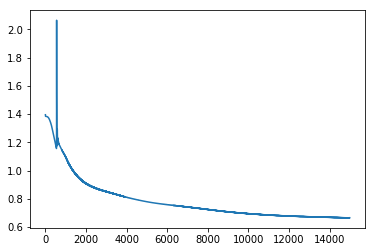

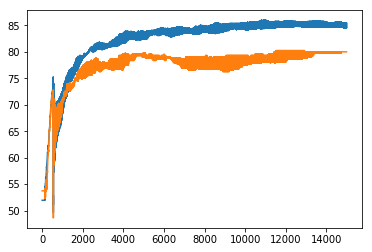

In [25]:
plt.plot(sigmoid_nnJ_history)
plt.show()
plt.plot(sigmoid_train_acc_history)
plt.plot(sigmoid_test_acc_history)
plt.show()

In [28]:
print("Result:")
pred_train = predict(sigmoid_Theta1, sigmoid_Theta2, x_train)
print("Training Set Accuracy:",sum(pred_train[:,np.newaxis]==y_train)[0]/y_train.shape[0]*100,"%")
pred_test = predict(sigmoid_Theta1, sigmoid_Theta2, x_test)
print("Test Set Accuracy:",sum(pred_test[:,np.newaxis]==y_test)[0]/y_test.shape[0]*100,"%")
print(max(sigmoid_test_acc_history))

Result:
Training Set Accuracy: 85.42635658914729 %
Test Set Accuracy: 80.0 %
80.23255813953489


## Task 3
### Implement Neural Network with ReLU as activation function

In [ ]:
initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)
initial_nn_params = np.append(initial_Theta1.flatten(),initial_Theta2.flatten())

print("Start training..")
relu_nnTheta, relu_nnJ_history= gradientDescentnn(x_train,y_train,initial_nn_params,0.2,25000,0,input_layer_size, hidden_layer_size, num_labels,Activation=ReLU)
relu_Theta1 = relu_nnTheta[:((input_layer_size+1) * hidden_layer_size)].reshape(hidden_layer_size,input_layer_size+1)
relu_Theta2 = relu_nnTheta[((input_layer_size +1)* hidden_layer_size ):].reshape(num_labels,hidden_layer_size+1)

### Visualize the lost history during the training time-ReLU

In [ ]:
plt.plot(relu_nnJ_history)

In [ ]:
print("Result:")
pred_train = predict(relu_Theta1, relu_Theta2, x_train,ReLU)
print("Training Set Accuracy:",sum(pred_train[:,np.newaxis]==y_train)[0]/y_train.shape[0]*100,"%")
pred_test = predict(relu_Theta1, relu_Theta2, x_test,ReLU)
print("Test Set Accuracy:",sum(pred_test[:,np.newaxis]==y_test)[0]/y_test.shape[0]*100,"%")

## Sigmoid and ReLU
- Sigmoid gradient <=1/4, while ReLU gradient is 0 or 1.
- For the same learning rate alpha, using ReLU helps learn much faster than sigmoid
- ReLU should not be used for output layer because of the range of it's ouput, and the compatibility to the cross Entropy loss function, which be used to evaluate the distance between 2 probability distributions.
- Dying ReLU problem
- Using ReLU, the learning rate alpha need to be small enough